# **Semantic Domain Assignments Task**
This section consists of the following steps:

1. Select a bible to use
2. Split the selected bible into chapter level
3. Tokenize/Lemmatize/Stopwords removal
4. Vectorize bible words and semantic domain words
5. Get a threshold from intra-distance of semantic domains
6. Get cosine similartiy between bible words and semantic domain words
7. Get diversity/depth score for each chapter
8. Convert each parallel corpora dataframe into input formats for JoeyNMT model
9. Exploratory Descriptive Analysis
10. SIL's request - semantic domain assignments in verse level

In [1]:
# Must run before any step

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Must run before any step

import os
import pandas as pd
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import operator
from collections import OrderedDict
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **1. Select a bible (english ver.) to use**
In this section, we calculated number of blanks and ranges in each english bible to choose one bible with the least number of both.

The bible we will use is **NIV11**. It has 0 ranges and 10,817 blanks. Even though this bible is not the one with the least number of blanks, it is considered to be one of the versions that are most closest to the original version of the bible which is in Hebrew and Greek.

This version of bible will be used in our rest of analysis.

In [ ]:
## Combine all 69 english bibles into a dataframe

path_src = '/content/drive/MyDrive/IP_main/data_bible/english_bibles_raw' # a directory of a folder that contains 69 different versions of bibles
src_file_list = os.listdir(path_src)

data={}
for file in src_file_list:
  with open(path_src + "/" + file, 'r') as b:
    file = file.strip('.txt')
    data[file] = b.readlines()

bible = pd.DataFrame(data)

# bible.to_csv("bible_en_all.csv") # Save the dataframe if needed

bible_en_all = pd.read_csv('/content/drive/MyDrive/IP_main/data_bible/bible_en_all.csv')
bible_en_all = bible_en_all.drop('Unnamed: 0', axis=1)
bible_en_all

,en-engOKE,en-TAZI-EN,en-engWMB,en-GNBDC,en-BSB,en-KJVA,en-ESVUK,en-FBVNTPsalms,en-EASY,en-RSV,...,en-GWC,en-MP1696,en-LSV,en-NASB,en-BCNen,en-NRSV,en-NJPS,en-engBren,en-NIV11,en-TTT
0,In the first times the Lord created the heaven...,\n,"In the beginning, God created the heavens and ...","In the beginning, when God created the univers...",In the beginning God created the heavens and t...,In the beginning God created the heaven and th...,"In the beginning, God created the heavens and ...",In the beginning God created the heavens and t...,"In the beginning, God made the heavens and the...",In the beginning God created the heavens and t...,...,\n,\n,In [the] beginning God created the heavens and...,In the beginning God created the heavens and t...,\n,In the beginning when God created the heavens ...,When God began to create heaven and earth—\n,In the beginning God made the heaven and the e...,In the beginning God created the heavens and t...,\n
1,"And the earth was waste and empty, and darknes...",\n,The earth was formless and empty. Darkness was...,the earth was formless and desolate. The ragin...,"Now the earth was formless and void, and darkn...","And the earth was without form, and void; and ...","The earth was without form and void, and darkn...","The earth was formless and empty, and darkness...",The earth was without shape and it was empty. ...,"The earth was without form and void, and darkn...",...,\n,\n,"and the earth was formless and void, and darkn...","The earth was formless and void, and darkness ...",\n,the earth was a formless void and darkness cov...,"the earth being unformed and void, with darkne...","But the earth was unsightly and unfurnished, a...","Now the earth was formless and empty, darkness...",\n
2,"And the Lord said, Let there be light; and the...",\n,"God said, “Let there be light,” and there was ...","Then God commanded, “Let there be light” — and...","And God said, “Let there be light,” and there ...","And God said, Let there be light: and there wa...","And God said, “Let there be light”, and there ...","God said, “Let there be light!” and there was ...","God said, ‘There will be light!’ And there was...","And God said, “Let there be light”; and there ...",...,\n,\n,"and God says, “Let light be”; and light is.\n","Then God said, “Let there be light”; and there...",\n,"Then God said, “Let there be light”; and there...","God said, “Let there be light”; and there was ...","And God said, Let there be light, and there wa...","And God said, “Let there be light,” and there ...",\n
3,And the Lord saw the light that it was good. A...,\n,"God saw the light, and saw that it was good. G...",God was pleased with what he saw. Then he sepa...,"And God saw that the light was good, and He se...","And God saw the light, that it was good: and G...",And God saw that the light was good. And God s...,"God saw that the light was good, and he separa...",God saw that the light was good. He separated ...,And God saw that the light was good; and God s...,...,\n,\n,"And God sees that the light [is] good, and God...",God saw that the light was good; and God separ...,\n,And God saw that the light was good; and God s...,"God saw that the light was good, and God separ...","And God saw the light that it was good, and Go...","God saw that the light was good, and he separa...",\n
4,"And the Lord called the light the Day, and the...",\n,"God called the light “day”, and the darkness h...",and he named the light “Day” and the darkness ...,"God called the light “day,” and the darkness H...","And God called the light Day, and the darkness...","God called the light Day, and the darkness he ...","God called the light “day,” and he called the ...",God called the light ‘day’. He called the dark...,"God called the light Day, and the darkness he ...",...,\n,\n,"and God calls the light “Day,” and the darknes...","God called the light day, and the darkness He ...",\n,"God called the light Day, and the darkness he ...","God called the light Day, a

In [ ]:
## identifying number of blanks('\n') by bible

blank_temp_bible = {}

for column in bible_en_all.columns:
  blank_lines = [sum(bible_en_all[column] == '\n')]
  blank_temp_bible[column] = blank_lines

blank_range_bibles_en = pd.DataFrame(blank_temp_bible).transpose().reset_index()
blank_range_bibles_en.columns = ['bible', 'num_blank']
blank_range_bibles_en = blank_range_bibles_en.sort_values(by = ['bible'], ascending = True)


## identifying number of <range> by bible

range_temp_bible = {}

for column in bible_en_all.columns:
  range_lines = [sum(bible_en_all[column] == '<range>\n')]
  range_temp_bible[column] = range_lines

range_by_bibles = pd.DataFrame(range_temp_bible).transpose().reset_index()
range_by_bibles.columns = ['bible', 'num_range']
range_by_bibles = range_by_bibles.sort_values(by = ['bible'], ascending = True)

blank_range_bibles_en['num_range'] = range_by_bibles['num_range']

In [ ]:
blank_range_bibles_en.sort_values(by = ['num_range']).head(40)

,bible,num_blank,num_range
16,en-ASVBT,39453,0
41,en-MP1650,39440,0
62,en-NASB,10801,0
67,en-NIV11,10817,0
20,en-NIV11R,10817,0
42,en-enggnv,10838,0
14,en-NIV84,10818,0
25,en-RV1885,10818,0
49,en-RV1895,5197,0
24,en-TEG,40609,0




### **2. Split into chapters (primarily by chapter level)**
In this section, we made 2 cleaned parallel corpora(eng-jav and eng-mal).

**Process**
- The verse-level corpora in each language(eng, jav, mal) was loaded.
- vref, eng, jav, mal were concatenated by columns and aligned into one dataframe
- The dataframe was splited into two prallel corpora(eng-jav and eng-mal)
- In each corpora dataframe, Blanks were identified and removed. (Rows with blank in either language were completely removed.)
- In each corpora dataframe, Ranges were identified and adjusted.

**Result**

There are 1144 chapters in eng+jav parallel data.

There are 335 chapters in eng+mal parallel data. 

**2.1. Align bible lines with vref**

In [3]:
## Split vref file into book, chapter, and verse columns

path_vref = '/content/drive/MyDrive/Colab Notebooks/vref_89.txt' # a directory for vref.txt (with 89 chapters, not 66 chapters)

with open(path_vref, 'r') as f:
  vref = f.readlines()

print("Total length of the original vref.txt file: {}".format(len(vref)))

## Split into book and chapter+verse first
vref_book = []
vref_chapter_verse = []

for line in vref:
  vref_book.append(line[:3])
  vref_chapter_verse.append(line[3:])

## Then split chapter and verse separately.
vref_chapter = []
vref_verse = []

for line in vref_chapter_verse:
  idx_temp = line.index(':')
  vref_chapter.append(line[:idx_temp].strip(" "))
  vref_verse.append(line[idx_temp+1:].strip("\n"))

vref_df_unprocessed = pd.DataFrame({'book':vref_book, 'chapter':vref_chapter, 'verse':vref_verse})
vref_df_unprocessed

Total length of the original vref.txt file: 41899


,book,chapter,verse
0,GEN,1,1
1,GEN,1,2
2,GEN,1,3
3,GEN,1,4
4,GEN,1,5
...,...,...,...
41894,ENO,42,12
41895,ENO,42,13
41896,ENO,42,14
41897,ENO,42,15


In [4]:
## Cut any chapters after REV

temp_list_books = vref_df_unprocessed['book'].unique().tolist()
idx = temp_list_books.index('REV') #65
irr_chp = temp_list_books[idx+1]
irr_index = vref_df_unprocessed['book'].tolist().index(irr_chp)
vref_df = vref_df_unprocessed.iloc[:irr_index,:]
print("Total length of the vref.txt after being processed(truncated): {}".format(len(vref_df)))
vref_df

Total length of the vref.txt after being processed(truncated): 31170


,book,chapter,verse
0,GEN,1,1
1,GEN,1,2
2,GEN,1,3
3,GEN,1,4
4,GEN,1,5
...,...,...,...
31165,REV,22,17
31166,REV,22,18
31167,REV,22,19
31168,REV,22,20


In [5]:
a = pd.DataFrame(vref_df.groupby(['book', 'chapter'], sort=False).first()).reset_index()
print("Total Number of unique chapters in this bible: ", len(a['chapter']))

Total Number of unique chapters in this bible:  1189


In [6]:
## Load NIV and clean

path_bible_niv = '/content/drive/MyDrive/Colab Notebooks/en-NIV11.txt'

with open(path_bible_niv, 'r') as f:
  lines = f.readlines()

## Striping '\n' at the end of every sentence
niv_unprocessed = [] # rows = 41899
for line in lines:
  if line != '\n':
    niv_unprocessed.append(line.strip('\n'))
  else:
    niv_unprocessed.append(line)

## Striping out '\n's after 31169th element
niv = niv_unprocessed[:31170]
print("First sentence in english:", niv[0])
print("Last sentence in english:", niv[-1])

First sentence in english: In the beginning God created the heavens and the earth.
Last sentence in english: The grace of the Lord Jesus be with Godʼs people. Amen.


In [7]:
## Load Javanese and clean

path_bible_jav = '/content/drive/MyDrive/Colab Notebooks/jv-JAV.txt'

with open(path_bible_jav, 'r') as f:
  lines = f.readlines()

## Striping '\n' at the end of every sentence
jav_unprocessed = [] # rows = 41899
for line in lines:
  if line != '\n':
    jav_unprocessed.append(line.strip('\n'))
  else:
    jav_unprocessed.append(line)

## Striping out '\n's after 31169th element
jav = jav_unprocessed[:31170]
print("First sentence in javanese:", jav[0])
print("Last sentence in javanese:", jav[-1])

First sentence in javanese: Ing jaman kawitan Gusti Allah nitahake langit lan bumi.
Last sentence in javanese: Sih-rahmate Gusti kita Yesus Kristus nunggila ing kowe kabeh! Amin.


In [8]:
jav_df_temp = pd.DataFrame(jav)
jav_df_temp.columns = ['sentences']
jav_df_temp

,sentences
0,Ing jaman kawitan Gusti Allah nitahake langit ...
1,"Anadene bumi mau campur-bawur lan suwung, sega..."
2,Gusti Allah banjur ngandika: “Anaa pepadhang!”...
3,Padhang mau dipirsani wus becik lan Gusti Alla...
4,"Kang padhang diparingi aran raina, dene kang p..."
...,...
31165,Apadene Sang Roh lan panganten putri padha nye...
31166,Aku pratela marang saben wong kang ngrungokake...
31167,Lan manawa ana wong kang ngurangi ing pangandi...
31168,Kang nglairake paseksen bab iki mau kabeh ngan...


In [9]:
## Load malay and clean

path_bible_mal = '/content/drive/MyDrive/Colab Notebooks/mkn-mkn.txt'

with open(path_bible_mal, 'r') as f:
  lines = f.readlines()

## Striping '\n' at the end of every sentence
mal_unprocessed = [] # rows = 41899
for line in lines:
  if line != '\n':
    mal_unprocessed.append(line.strip('\n'))
  else:
    mal_unprocessed.append(line)

## Striping out '\n's after 31169th element
mal = mal_unprocessed[:31170]
print("First sentence in malay:", mal[0])
print("Last sentence in malay:", mal[-1])

First sentence in malay: Mula-mula Tuhan Allah bekin langit deng bumi.
Last sentence in malay: Beta minta ko Tuhan Yesus kasi tunju Dia pung hati bae sang Dia pung orang dong samua. Amin! Dari beta, Yohanis


In [10]:
## Align with vref 89, niv, jav, mal, and sequence of chapters

vref_df['english'] = niv
vref_df['javanese'] = jav
vref_df['malay'] = mal

## Get a sequence of chapters 
list_books_eng_jav_mal = vref_df['book'].unique().tolist()
temp_chp_num_ext = []

k = 0
for book in list_books_eng_jav_mal:
  df_temp = vref_df[vref_df['book'] == book]
  unique_chps = df_temp['chapter'].tolist()
  for j in unique_chps:
    temp_chp_num_ext.append(k+int(j))
  k = temp_chp_num_ext[-1]

vref_df['chapter_seq'] = temp_chp_num_ext

vref_df_all = vref_df[['book', 'chapter', 'verse', 'chapter_seq', 'english', 'javanese', 'malay']]
vref_df_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,book,chapter,verse,chapter_seq,english,javanese,malay
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...,Mula-mula Tuhan Allah bekin langit deng bumi.
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega...","Itu waktu, bumi balóm jadi, deng samua masi ha..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...,"Ais Tuhan Allah omong bilang, “Musti ada tarán..."
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...,"Lia itu taráng, ju Dia pung hati sanáng, tagal..."
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p...","Dia kasi nama taráng tu, ‘siang’, deng galáp t..."
...,...,...,...,...,...,...,...
31165,REV,22,17,1189,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...,"Tuhan Allah pung Roh ada undang bilang, “Mari ..."
31166,REV,22,18,1189,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...,"Beta, Yohanis ni, kasi inga samua orang yang n..."
31167,REV,22,19,1189,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...,Deng kalo ada orang yang kasi kurang apa-apa l...
31168,REV,22,20,1189,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...,Yesus sandiri yang su buka kasi lia ini hal sa...


In [11]:
## split this dataframe into two dataframes: eng+jav and eng+mal
## While splitting, identify blanks in each pair and delete them.

index_blank_eng_jav = vref_df_all.loc[(vref_df_all['english'] == "\n") | (vref_df_all['javanese'] == "\n")].index.tolist()
index_blank_eng_mal = vref_df_all.loc[(vref_df_all['english'] == "\n") | (vref_df_all['malay'] == "\n")].index.tolist()

print("In eng+jav dataframe, {} blanks exist.".format(len(index_blank_eng_jav)))
print("In eng+mal dataframe, {} blanks exist.".format(len(index_blank_eng_mal)))

In eng+jav dataframe, 1215 blanks exist.
In eng+mal dataframe, 21342 blanks exist.


In [12]:
## master version dataframe for eng+jav
## process <range> in javanese. There is only one <range> in javanese

vref_df_eng_jav = vref_df_all.drop(index_blank_eng_jav).reset_index(drop=True)
vref_df_eng_jav = vref_df_eng_jav.iloc[:,:6]
vref_df_eng_jav

index_range_jav = vref_df_eng_jav[vref_df_eng_jav['javanese']=='<range>'].reset_index().iloc[0,0]
eng_list = vref_df_eng_jav['english'].tolist()
eng_list[index_range_jav-1] = eng_list[index_range_jav-1] + str(" ") + eng_list[index_range_jav]

vref_df_eng_jav['english'] = eng_list
vref_df_eng_jav = vref_df_eng_jav.drop(index_range_jav).reset_index(drop=True)
vref_df_eng_jav

,book,chapter,verse,chapter_seq,english,javanese
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p..."
...,...,...,...,...,...,...
29949,REV,22,17,1189,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...
29950,REV,22,18,1189,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...
29951,REV,22,19,1189,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...
29952,REV,22,20,1189,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...


In [13]:
## make new chapter sequence - eng+jav
list_books_eng_jav = vref_df_eng_jav['book'].unique().tolist()
new_chapter_seq_jav = []

i=0
for book in list_books_eng_jav:
  df_temp = vref_df_eng_jav[vref_df_eng_jav['book'] == book]
  duplicate_chps = df_temp['chapter'].tolist()
  for chps in duplicate_chps:
    new_chapter_seq_jav.append(i+int(chps))
  i = new_chapter_seq_jav[-1]

vref_df_eng_jav['chapter_seq'] = new_chapter_seq_jav
vref_df_eng_jav

,book,chapter,verse,chapter_seq,english,javanese
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p..."
...,...,...,...,...,...,...
29949,REV,22,17,1144,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...
29950,REV,22,18,1144,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...
29951,REV,22,19,1144,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...
29952,REV,22,20,1144,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...


In [14]:
## master version dataframe for eng+mal
## process <range> in malay.

vref_df_eng_mal = vref_df_all.drop(index_blank_eng_mal).reset_index(drop=True)
vref_df_eng_mal = vref_df_eng_mal.loc[:,['book', 'chapter', 'verse', 'chapter_seq', 'english', 'malay']]

while vref_df_eng_mal[vref_df_eng_mal['english']==''].chapter.count() < vref_df_eng_mal[vref_df_eng_mal['malay']=='<range>'].chapter.count():
  for i in range(len(vref_df_eng_mal)):
    z = vref_df_eng_mal['book'].count()
    if vref_df_eng_mal.at[i,'malay'] == '<range>':
      if vref_df_eng_mal.at[i-1,'english'] == '':
        vref_df_eng_mal.at[i-1,'english'] = str(vref_df_eng_mal.at[i, 'english'])
      else:
        vref_df_eng_mal.at[i-1, 'english'] = str(vref_df_eng_mal.at[i-1, 'english']) + ' ' + str(vref_df_eng_mal.at[i, 'english'])
      vref_df_eng_mal.at[i,'english'] = ''

index_range_mal = vref_df_eng_mal[vref_df_eng_mal['malay']=='<range>'].index.tolist()

vref_df_eng_mal = vref_df_eng_mal.drop(index_range_mal).reset_index(drop=True)
vref_df_eng_mal

,book,chapter,verse,chapter_seq,english,malay
0,GEN,1,1,1,In the beginning God created the heavens and t...,Mula-mula Tuhan Allah bekin langit deng bumi.
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Itu waktu, bumi balóm jadi, deng samua masi ha..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...","Ais Tuhan Allah omong bilang, “Musti ada tarán..."
3,GEN,1,4,1,"God saw that the light was good, and he separa...","Lia itu taráng, ju Dia pung hati sanáng, tagal..."
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Dia kasi nama taráng tu, ‘siang’, deng galáp t..."
...,...,...,...,...,...,...
9391,REV,22,17,1189,"The Spirit and the bride say, “Come!” And let ...","Tuhan Allah pung Roh ada undang bilang, “Mari ..."
9392,REV,22,18,1189,I warn everyone who hears the words of the pro...,"Beta, Yohanis ni, kasi inga samua orang yang n..."
9393,REV,22,19,1189,And if anyone takes words away from this scrol...,Deng kalo ada orang yang kasi kurang apa-apa l...
9394,REV,22,20,1189,"He who testifies to these things says, “Yes, I...",Yesus sandiri yang su buka kasi lia ini hal sa...


In [15]:
## make new chapter sequence - eng+mal
list_books_eng_mal = vref_df_eng_mal['book'].unique().tolist()
new_chapter_seq_mal = []

i=0
for book in list_books_eng_mal:
  df_temp = vref_df_eng_mal[vref_df_eng_mal['book'] == book]
  duplicate_chps = df_temp['chapter'].tolist()
  duplicate_chps = [int(i) for i in duplicate_chps]
  duplicate_chps_seq = []
  for idx, j in enumerate(duplicate_chps):
    if idx == 0:
      duplicate_chps_seq.append(j)
    else:
      if duplicate_chps[idx] - duplicate_chps[idx-1] == 0 or duplicate_chps[idx] - duplicate_chps[idx-1] == 1:
        duplicate_chps_seq.append(j)
      else:
        indices = [q for q, x in enumerate(duplicate_chps) if x == j]
        k = duplicate_chps[idx-1]+1
        for z in range(indices[0], indices[-1]+1):
          duplicate_chps[z] = k
        duplicate_chps_seq.append(k)
  for s in duplicate_chps_seq:
    new_chapter_seq_mal.append(i+int(s))
  i = new_chapter_seq_mal[-1]

vref_df_eng_mal['chapter_seq'] = new_chapter_seq_mal
vref_df_eng_mal

,book,chapter,verse,chapter_seq,english,malay
0,GEN,1,1,1,In the beginning God created the heavens and t...,Mula-mula Tuhan Allah bekin langit deng bumi.
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Itu waktu, bumi balóm jadi, deng samua masi ha..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...","Ais Tuhan Allah omong bilang, “Musti ada tarán..."
3,GEN,1,4,1,"God saw that the light was good, and he separa...","Lia itu taráng, ju Dia pung hati sanáng, tagal..."
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Dia kasi nama taráng tu, ‘siang’, deng galáp t..."
...,...,...,...,...,...,...
9391,REV,22,17,335,"The Spirit and the bride say, “Come!” And let ...","Tuhan Allah pung Roh ada undang bilang, “Mari ..."
9392,REV,22,18,335,I warn everyone who hears the words of the pro...,"Beta, Yohanis ni, kasi inga samua orang yang n..."
9393,REV,22,19,335,And if anyone takes words away from this scrol...,Deng kalo ada orang yang kasi kurang apa-apa l...
9394,REV,22,20,335,"He who testifies to these things says, “Yes, I...",Yesus sandiri yang su buka kasi lia ini hal sa...


**2.2. chapter level split (eng+jav and eng+mal versions)**

In [16]:
## Save in dictionary format (eng+jav)

list_books_eng_jav = vref_df_eng_jav['book'].unique().tolist()
chp_dict_eng_jav = {} # <- {'GEN1':['all sentences in GEN1'], 'GEN2':['all sentences in GEN2'], ... ,'REV22':['all sentences in REV22']} in english
chp_dict_jav = {}     # <- {'GEN1':['all sentences in GEN1'], 'GEN2':['all sentences in GEN2'], ... ,'REV22':['all sentences in REV22']} in javanese

for book in list_books_eng_jav:
  df_temp = vref_df_eng_jav[vref_df_eng_jav['book'] == book]
  unique_chps = df_temp['chapter'].unique().tolist()
  for chps in unique_chps:
    df_temp2 = df_temp[df_temp['chapter'] == chps]
    chp_dict_eng_jav[str(book)+str(chps)] = df_temp2['english'].tolist()
    chp_dict_jav[str(book)+str(chps)] = df_temp2['javanese'].tolist()


## Save in dictionary format (eng+mal)

list_books_eng_mal = vref_df_eng_mal['book'].unique().tolist()
chp_dict_eng_mal = {} # <- {'GEN1':['all sentences in GEN1'], 'GEN2':['all sentences in GEN2'], ... ,'REV22':['all sentences in REV22']} in english
chp_dict_mal = {}     # <- {'GEN1':['all sentences in GEN1'], 'GEN2':['all sentences in GEN2'], ... ,'REV22':['all sentences in REV22']} in malay

for book in list_books_eng_mal:
  df_temp = vref_df_eng_mal[vref_df_eng_mal['book'] == book]
  unique_chps = df_temp['chapter'].unique().tolist()
  for chps in unique_chps:
    df_temp2 = df_temp[df_temp['chapter'] == chps]
    chp_dict_eng_mal[str(book)+str(chps)] = df_temp2['english'].tolist()
    chp_dict_mal[str(book)+str(chps)] = df_temp2['malay'].tolist()

In [17]:
## Save in list format for easy analysis (english - version of javanese alignment)

chp_listOfList_eng_jav = [] # <- [['all sentences in GEN1'], ['all sentences in GEN2'], ... ['all sentences in REV22']] in english

for k,v in chp_dict_eng_jav.items():
  chp_listOfList_eng_jav.append(v)


## Save in list format for easy analysis (javanese)

chp_listOfList_jav = [] # <- [['all sentences in GEN1'], ['all sentences in GEN2'], ... ['all sentences in REV22']] in javanese

for k,v in chp_dict_jav.items():
  chp_listOfList_jav.append(v)


## Save in list format for easy analysis (english - version of malay alignment)

chp_listOfList_eng_mal = [] # <- [['all sentences in GEN1'], ['all sentences in GEN2'], ... ['all sentences in REV22']] in english

for k,v in chp_dict_eng_mal.items():
  chp_listOfList_eng_mal.append(v)


## Save in list format for easy analysis (malay)

chp_listOfList_mal = [] # <- [['all sentences in GEN1'], ['all sentences in GEN2'], ... ['all sentences in REV22']] in malay

for k,v in chp_dict_mal.items():
  chp_listOfList_mal.append(v)

In [20]:
chp_listOfList_eng_jav[0]

['In the beginning God created the heavens and the earth.',
 'Now the earth was formless and empty, darkness was over the surface of the deep, and the Spirit of God was hovering over the waters.',
 'And God said, “Let there be light,” and there was light.',
 'God saw that the light was good, and he separated the light from the darkness.',
 'God called the light “day,” and the darkness he called “night.” And there was evening, and there was morning—the first day.',
 'And God said, “Let there be a vault between the waters to separate water from water.”',
 'So God made the vault and separated the water under the vault from the water above it. And it was so.',
 'God called the vault “sky.” And there was evening, and there was morning—the second day.',
 'And God said, “Let the water under the sky be gathered to one place, and let dry ground appear.” And it was so.',
 'God called the dry ground “land,” and the gathered waters he called “seas.” And God saw that it was good.',
 'Then God said,

In [18]:
print("vref_df_eng_jav")
print("Length of chapters for eng in eng-jav data frame:", len(chp_listOfList_eng_jav))
print("Length of chapters for jav in eng-jav data frame:", len(chp_listOfList_jav))
print()
print("vref_df_eng_mal")
print("Length of chapters for eng in eng-mal data frame:", len(chp_listOfList_eng_mal))
print("Length of chapters for mal in eng-mal data frame:", len(chp_listOfList_mal))

vref_df_eng_jav
Length of chapters for eng in eng-jav data frame: 1144
Length of chapters for jav in eng-jav data frame: 1144

vref_df_eng_mal
Length of chapters for eng in eng-mal data frame: 335
Length of chapters for mal in eng-mal data frame: 335


### **3. Tokenize/Lemmatize/Removal of Stopwords**
Each parallel corpora dataframe was processed by tokenization, lemmatization and removal of stopwords for dimension reduction for further process.

**- Tokenization:** splitting a sentence into word level

**- Lemmatization:** convert each word into root word (ex. past tense -> present tense | plural -> singular)

**- Stopwords removal:** removing irrelevant words such as a, the, an, like, with, etc.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**3.1. text representation for bible splitted by chapters**

In [ ]:
## Make the chp_list (list of lists) into list (english in eng-jav)

chp_list_eng_jav = [] # <- ['all sentences in GEN1', 'all sentences in GEN2', ... 'all sentences in REV22'] in english

for chp in chp_listOfList_eng_jav:
  chp_list_eng_jav.append(" ".join(chp))


## Make the chp_list (list of lists) into list (javanese)

chp_list_jav = [] # <- ['all sentences in GEN1', 'all sentences in GEN2', ... 'all sentences in REV22'] in javanese

for chp in chp_listOfList_jav:
  chp_list_jav.append(" ".join(chp))



## Make the chp_list (list of lists) into list (english in eng-mal)

chp_list_eng_mal = [] # <- ['all sentences in GEN1', 'all sentences in GEN2', ... 'all sentences in REV22'] in english

for chp in chp_listOfList_eng_mal:
  chp_list_eng_mal.append(" ".join(chp))


## Make the chp_list (list of lists) into list (malay)

chp_list_mal = [] # <- ['all sentences in GEN1', 'all sentences in GEN2', ... 'all sentences in REV22'] in malay

for chp in chp_listOfList_mal:
  chp_list_mal.append(" ".join(chp))


print(len(chp_list_eng_jav))
print(len(chp_list_jav))
print(len(chp_list_eng_mal))
print(len(chp_list_mal))

1144
1144
335
335


In [19]:
chp_list_eng_jav[0]

NameError: ignored

In [ ]:
## NLTK english in eng-jav version

## Tokenize
token=[]
for i in chp_list_eng_jav:
    token.append(nltk.word_tokenize(i))

## Lemmatize
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_token=[]
for i in token:
    lemmatized_token.append([(lemmatizer.lemmatize(token.lower())) for token in i])
    
## Stopwords removal
tok_chp_eng_jav =[]
from nltk.corpus import stopwords
for i in lemmatized_token :
    tok_chp_eng_jav.append([token for token in i if token.isalpha() if not token in stopwords.words('english')])

In [ ]:
## NLTK english in eng-mal version

## Tokenize
token=[]
for i in chp_list_eng_mal:
    token.append(nltk.word_tokenize(i))

## Lemmatize
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_token=[]
for i in token:
    lemmatized_token.append([(lemmatizer.lemmatize(token.lower())) for token in i])
    
## Stopwords removal
tok_chp_eng_mal =[]
from nltk.corpus import stopwords
for i in lemmatized_token :
    tok_chp_eng_mal.append([token for token in i if token.isalpha() if not token in stopwords.words('english')])

In [ ]:
print(len(tok_chp_eng_jav))
print(len(tok_chp_eng_mal))

1144
335


### **4. Vectorize words from the bible and semantic domain words**
Each process word in each chapter in english bible in each parallel corpora and a collection of semantic domain words was vectorized using fasttext library, which convert each word into 300 dimensional numpy array.

In [ ]:
# Use fast text
pip install fasttext
import fasttext
import fasttext.util

## If you want to download the model from the internet
# fasttext.util.download_model('en', if_exists='ignore')  # English
# wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

## If you have a file in local
path_model = '/content/drive/MyDrive/Colab Notebooks/cc.en.300.bin'

## Initializing the model
model = fasttext.load_model(path_model)

# # Use sentence-transformation
# pip install sentence-transformers
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-mpnet-base-v2')

**4.1. vectorize english words**

In [ ]:
## Embedding for english in eng-jav version
## output format1: [[chapter1], [chapter2], ...]
## output format2: [['word1', 'word2', 'word3', ... ], [['word1', 'word2', 'word3', ... ], ...]
## output format3: [[array(300,), array(300,), array(300,), ... ], [[array(300,), array(300,), array(300,), ... ], ...]

start_time = time.time()

emb_eng_jav = []
for chapter in tok_chp_eng_jav:
  emb_temp = []
  for word in chapter:
    emb_1 = model.get_word_vector(word)
    emb_temp.append(emb_1)
  emb_eng_jav.append(emb_temp)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes)

4.00871467590332


In [ ]:
## Embedding for english in eng-mal version
## output format1: [[chapter1], [chapter2], ...]
## output format2: [['word1', 'word2', 'word3', ... ], [['word1', 'word2', 'word3', ... ], ...]
## output format3: [[array(300,), array(300,), array(300,), ... ], [[array(300,), array(300,), array(300,), ... ], ...]

start_time = time.time()

emb_eng_mal = []
for chapter in tok_chp_eng_mal:
  emb_temp = []
  for word in chapter:
    emb_1 = model.get_word_vector(word)
    emb_temp.append(emb_1)
  emb_eng_mal.append(emb_temp)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes)

1.851431131362915


In [ ]:
print(len(emb_eng_jav))
print(len(emb_eng_mal))

1144
335


**4.2. vectorize semantic domain words**

In [ ]:
# Loading semantic domains
path2 = '/content/drive/MyDrive/Colab Notebooks/semdom_words_eng.csv' ## a directory for semantic domain words

sds = pd.read_csv(path2)
sds = sds.category.unique().tolist()

In [ ]:
sds_df = pd.DataFrame(sds)
sds_df.head(12)
sds_df.columns = ['Semantic Domains']
sds_df

,Semantic Domains
0,Moon
1,Star
2,Planet
3,Sun
4,Blow air
...,...
1778,Names of rivers
1779,Name of a place
1780,Names of animals
1781,Names of buildings


In [ ]:
## Embedding for semantic domains
start_time = time.time()

emb_sds = []

for sd in sds:
  if " " in sd:
    vec = model.get_sentence_vector(sd)
    emb_sds.append(vec)
  else:
    vec = model.get_word_vector(sd)
    emb_sds.append(vec)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes)

0.04995417594909668


In [ ]:
# # Saving embedded_sds

# path_emb_sds = '/content/drive/MyDrive/Colab Notebooks/saved_files/embedded_sds_list.pkl'

# with open(path_emb_sds, 'wb') as f:
#   pickle.dump(embedded_sds, f)

### **5. Get a threshold from intra-distance of semantic domains**
To choose words that are closed to each other based on cosine similarity, we need to have some sort of threshold.

To get the threshold, we calculated intra distance of each semantic domain word. In other words, a distance between every single combination of a pair of semantic domain was calculated.

Within the collection of distance between every pair of semantic domain, 99, 95, and 75 percentile numbers were calculated and used as thresholds.

The 95 percentile (0.32) was chosen as a threshold. The 99 percentile was too strick as it tends to choose bible words that were exactly same as semantic domain word. The 75 percentile was too flexible, as it tends to even choose the bible words that were irrelevant to the semantic domain word.

In [ ]:
# # Openning inter_cosine_sds

# path_inter_cosine_sds = '/content/drive/MyDrive/Colab Notebooks/saved_files/inter_cosine_sds.pkl'

# with open(path_inter_cosine_sds, 'rb') as f:
#   inter_cosine_sds = pickle.load(f)

In [ ]:
# pip install numba

In [ ]:
from numba import jit

@jit(nopython=True)
def cosine_similarity_numba(u:np.ndarray, v:np.ndarray):
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu!=0 and vv!=0:
        cos_theta = uv/np.sqrt(uu*vv)
    return cos_theta

In [ ]:
## Determining threshold 1 - get a cosine similarity of sd

inter_cosine_sds = []

start_time = time.time()

for i in emb_sds:
  for j in emb_sds:
    score = cosine_similarity_numba(i, j)
    inter_cosine_sds.append(score)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes)

10.490773439407349


In [ ]:
# # Saving inter_cosine_sds

# path_inter_cosine_sds = '/content/drive/MyDrive/Colab Notebooks/saved_files/inter_cosine_sds.pkl'

# with open(path_inter_cosine_sds, 'wb') as f:
#   pickle.dump(inter_cosine_sds, f)

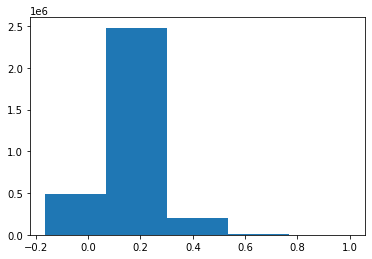

In [ ]:
## Determining threshold 2 - histogram

plt.hist(inter_cosine_sds, bins=5)
plt.show()

In [ ]:
th_99 = np.quantile(inter_cosine_sds, 0.99)
th_95 = np.quantile(inter_cosine_sds, 0.95)
th_75 = np.quantile(inter_cosine_sds, 0.75)
th_mean = np.mean(inter_cosine_sds)

print("99th percentile:", th_99)
print("95th percentile:", th_95)
print("75th percentile:", th_75)
print("mean:", th_mean)

99th percentile: 0.44784054107824983
95th percentile: 0.32180874917238195
75th percentile: 0.207955500875624
mean: 0.15804943751053296


### **6. Get cosine similartiy and find frequency of words that correspond to each semantic domain by chapter**

The cosine similarity between every word in bible in each parallel corpora and semantic domain word was calculated and the pair that was above the threshold was selected 

**The 'chatpers' and 'chapters_words' variables:** A list of dictionary which stores the number of selected words or words themselves from bible in semantic domain by chapter. The number of dictionary is same as number of chapters in each parallel corpora.


**- chapters:** This variable contains **number of selected words** from bible in each semantic domain word by chapter. The english sentences used here are the one in **eng-jav parallel corpora.**

**- chapters_2:** This variable contains **number of selected words** of words from bible in each semantic domain word by chapter. The english sentences used here are the one in **eng-mal parallel corpora.**

**- chapters_words:** This variable contains **selected words** of words from bible in each semantic domain word by chapter. The english sentences used here are the one in **eng-jav parallel corpora.**

**- chapters_words_2:** This variable contains **selected words** of words from bible in each semantic domain word by chapter. The english sentences used here are the one in **eng-mal parallel corpora.**

**6.1. english-javanese version**

In [ ]:
# Openning chapter - th 95

path_chapters = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_jav_95.pkl'
path_chapters_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_jav_95.pkl'

with open(path_chapters, 'rb') as f:
  chapters = pickle.load(f)

with open(path_chapters_words, 'rb') as f:
  chapters_words = pickle.load(f)


# # Openning chapter - th 99

# path_chapters = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_jav_99.pkl'
# path_chapters_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_jav_99.pkl'

# with open(path_chapters, 'rb') as f:
#   chapters = pickle.load(f)

# with open(path_chapters_words, 'rb') as f:
#   chapters_words = pickle.load(f)


# # Openning chapter - th 75

# path_chapters = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_jav_75.pkl'
# path_chapters_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_jav_75.pkl'

# with open(path_chapters, 'rb') as f:
#   chapters = pickle.load(f)

# with open(path_chapters_words, 'rb') as f:
#   chapters_words = pickle.load(f)

In [ ]:
## ## Getting Cosine Simliarity for one chapter with all sds

start_time = time.time()

th = th_95 # 99, 95, or 75

chapters = [] # <- count of words of corresponding semantic domains by chapters
chapters_words = [] # <- corresponding words to semantic domains by chapters

for i in range(len(tok_chp_eng_jav)):
    sd_dict = {j:0 for j in sds}
    sd_dict_words = {k:[] for k in sds}
    for idx1, sd_vec in enumerate(emb_sds):
        for idx2, word_vec in enumerate(emb_eng_jav[i]):
            score = cosine_similarity_numba(sd_vec, word_vec)
            if score > th:
                sd_dict[sds[idx1]] += 1
                sd_dict_words[sds[idx1]].append(tok_chp_eng_jav[i][idx2])
    chapters.append(sd_dict)
    chapters_words.append(sd_dict_words)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes, "seconds")

In [ ]:
# ## Saving chapter - th 95

# path_chapters = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_jav_95.pkl'
# path_chapters_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_jav_95.pkl'

# with open(path_chapters, 'wb') as f:
#   pickle.dump(chapters, f)

# with open(path_chapters_words, 'wb') as f:
#   pickle.dump(chapters_words, f)


# ## Saving chapter - th 99

# path_chapters = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_jav_99.pkl'
# path_chapters_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_jav_99.pkl'

# with open(path_chapters, 'wb') as f:
#   pickle.dump(chapters, f)

# with open(path_chapters_words, 'wb') as f:
#   pickle.dump(chapters_words, f)


# ## Saving chapter - th 75

# path_chapters = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_jav_75.pkl'
# path_chapters_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_jav_75.pkl'

# with open(path_chapters, 'wb') as f:
#   pickle.dump(chapters, f)

# with open(path_chapters_words, 'wb') as f:
#   pickle.dump(chapters_words, f)

**6.2. english-malay version**

In [ ]:
# Openning chapter - th 95

path_chapters_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_mal_95.pkl'
path_chapters_words_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_mal_95.pkl'

with open(path_chapters_2, 'rb') as f:
  chapters_2 = pickle.load(f)

with open(path_chapters_words_2, 'rb') as f:
  chapters_words_2 = pickle.load(f)


# # Openning chapter - th 99

# path_chapters_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_mal_99.pkl'
# path_chapters_words_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_mal_99.pkl'

# with open(path_chapters_2, 'rb') as f:
#   chapters_2 = pickle.load(f)

# with open(path_chapters_words_2, 'rb') as f:
#   chapters_words_2 = pickle.load(f)


# # Openning chapter - th 75

# path_chapters_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_mal_75.pkl'
# path_chapters_words_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_mal_75.pkl'

# with open(path_chapters_2, 'rb') as f:
#   chapters_2 = pickle.load(f)

# with open(path_chapters_words_2, 'rb') as f:
#   chapters_words_2 = pickle.load(f)75

In [ ]:
## ## Getting Cosine Simliarity for one chapter with all sds

start_time = time.time()

th = th_95 # 99, 95, or 75

chapters_2 = [] # <- count of words of corresponding semantic domains by chapters
chapters_words_2 = [] # <- corresponding words to semantic domains by chapters

for i in range(len(tok_chp_eng_mal)):
    sd_dict = {j:0 for j in sds}
    sd_dict_words = {k:[] for k in sds}
    for idx1, sd_vec in enumerate(emb_sds):
        for idx2, word_vec in enumerate(emb_eng_mal[i]):
            score = cosine_similarity_numba(sd_vec, word_vec)
            if score > th:
                sd_dict[sds[idx1]] += 1
                sd_dict_words[sds[idx1]].append(tok_chp_eng_mal[i][idx2])
    chapters_2.append(sd_dict)
    chapters_words_2.append(sd_dict_words)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes, "seconds")

In [ ]:
# ## Saving chapter - th 95

# path_chapters_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_mal_95.pkl'
# path_chapters_words_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_mal_95.pkl'

# with open(path_chapters_2, 'wb') as f:
#   pickle.dump(chapters_2, f)

# with open(path_chapters_words_2, 'wb') as f:
#   pickle.dump(chapters_words_2, f)


# # ## Saving chapter - th 99

# # path_chapters_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_mal_99.pkl'
# # path_chapters_words_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_mal_99.pkl'

# with open(path_chapters_2, 'wb') as f:
#   pickle.dump(chapters_2, f)

# with open(path_chapters_words_2, 'wb') as f:
#   pickle.dump(chapters_words_2, f)

# # ## Saving chapter - th 75

# # path_chapters_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_mal_75.pkl'
# # path_chapters_words_2 = '/content/drive/MyDrive/Colab Notebooks/saved_files/chapters_words_mal_75.pkl'

# with open(path_chapters_2, 'wb') as f:
#   pickle.dump(chapters_2, f)

# with open(path_chapters_words_2, 'wb') as f:
#   pickle.dump(chapters_words_2, f)

### **7. Get diversity/depth score for each chapter**

From the previous step, we could get a **Semantic Domain Distribution Table (SDDT)** which contains number of selected words corresponding to each semantic domain by each chatper.

**-chs_df:** a dataframe of SDDT of english bible from **eng-jav** parallel corpora

**-chs_df_2:** a dataframe of SDDT of english bible from **eng-mal** parallel corpora

Based on the SDDT, we calculated diversity and depth, the measures that will be used to order chapters differently. Other measurements were created to be experimented (diversity per length, depth per length, diversity * depth)

**-master_df_en_jv:** master version of cleaned eng-jav parallel corpora with the 5 measurements

**-master_df_en_ml:** master version of cleaned eng-mal parallel corpora with the 5 measurements


In [ ]:
# Chang into df - eng+jav version

chs = {i+1:w for i,w in enumerate(chapters)}
chs_df = pd.DataFrame(chs)
# chs_df.to_csv("chs_df.csv")

chs_df

,1,2,3,4,5,6,7,8,9,10,...,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144
Moon,7,2,0,0,0,0,0,1,1,0,...,0,0,0,3,0,0,1,0,2,1
Star,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Planet,7,6,0,1,0,12,14,9,7,3,...,5,6,0,1,5,6,2,2,3,0
Sun,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,1,0,2,1
Blow air,14,5,3,1,0,1,9,13,2,0,...,5,3,2,7,7,4,3,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Names of rivers,19,11,0,3,0,4,8,10,6,2,...,20,6,5,13,9,8,10,9,10,6
Name of a place,53,33,18,18,38,28,38,29,21,9,...,42,25,14,29,23,31,22,24,38,30
Names of animals,12,11,5,4,0,6,13,7,7,2,...,17,4,3,6,6,7,6,4,6,2
Names of buildings,3,6,0,5,0,4,2,1,3,3,...,17,5,3,8,7,11,6,5,17,6


In [ ]:
# Chang into df - eng+mal version

chs_2 = {i+1:w for i,w in enumerate(chapters_2)}
chs_df_2 = pd.DataFrame(chs_2)
# chs_df_2.to_csv("chs_df_2.csv")

chs_df_2

,1,2,3,4,5,6,7,8,9,10,...,326,327,328,329,330,331,332,333,334,335
Moon,7,2,0,0,0,0,0,1,1,0,...,0,0,0,3,0,0,1,0,2,1
Star,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Planet,7,6,0,1,0,12,14,9,7,3,...,5,6,0,1,5,6,2,2,3,0
Sun,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,1,0,2,1
Blow air,14,5,3,1,0,1,9,13,2,0,...,5,3,2,7,7,4,3,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Names of rivers,19,11,0,3,0,4,8,10,6,2,...,20,6,5,13,9,8,10,9,10,6
Name of a place,53,33,18,18,38,28,38,29,21,9,...,42,25,14,29,23,31,22,24,38,30
Names of animals,12,11,5,4,0,6,13,7,7,2,...,17,4,3,6,6,7,6,4,6,2
Names of buildings,3,6,0,5,0,4,2,1,3,3,...,17,5,3,8,7,11,6,5,17,6


**7.1. eng+jav version**

In [ ]:
## Diversity - simple proportion method(%)

diversity = {}
diversity_score = {}

for i in range(len(chs_df.columns)):
  diversity[i+1] = sum(chs_df[i+1] != 0)
  diversity_score[i+1] = round((diversity[i+1] / len(chs_df)), 2) * 100

print(diversity)
print(diversity_score)

{1: 719, 2: 743, 3: 747, 4: 791, 5: 303, 6: 715, 7: 656, 8: 702, 9: 747, 10: 536, 11: 596, 12: 623, 13: 672, 14: 725, 15: 701, 16: 622, 17: 585, 18: 787, 19: 814, 20: 634, 21: 757, 22: 658, 23: 566, 24: 870, 25: 786, 26: 783, 27: 850, 28: 701, 29: 719, 30: 834, 31: 897, 32: 746, 33: 667, 34: 769, 35: 667, 36: 562, 37: 795, 38: 722, 39: 616, 40: 634, 41: 887, 42: 790, 43: 789, 44: 791, 45: 729, 46: 694, 47: 787, 48: 664, 49: 900, 50: 725, 51: 621, 52: 708, 53: 701, 54: 781, 55: 658, 56: 588, 57: 732, 58: 688, 59: 801, 60: 786, 61: 566, 62: 917, 63: 757, 64: 691, 65: 785, 66: 793, 67: 667, 68: 742, 69: 733, 70: 748, 71: 847, 72: 797, 73: 930, 74: 637, 75: 702, 76: 600, 77: 652, 78: 694, 79: 785, 80: 821, 81: 657, 82: 834, 83: 648, 84: 903, 85: 727, 86: 651, 87: 534, 88: 671, 89: 648, 90: 571, 91: 656, 92: 540, 93: 575, 94: 734, 95: 814, 96: 741, 97: 761, 98: 694, 99: 663, 100: 737, 101: 711, 102: 512, 103: 686, 104: 801, 105: 645, 106: 778, 107: 623, 108: 633, 109: 891, 110: 736, 111: 68

In [ ]:
## Depth

chs_df_squared = chs_df ** 2
chs_df_squared['Total'] = chs_df_squared.sum(axis=1)
chs_df_sum = chs_df_squared.append(chs_df_squared.sum(), ignore_index=True)
chs_df_sum

depth_temp = {}
for i in range(len(chs_df_sum.columns)):
  depth_temp[i+1] = round(chs_df_sum.iloc[-1,i] / chs_df_sum.iloc[-1,-1] * 100, 6)

depth_df = pd.DataFrame(depth_temp, index=['0']).transpose().reset_index()
depth_df.columns = ['chapter', 'depth_temp']
depth_df = depth_df[:1144]

depth_list = []
for i in range(len(depth_df)):
  depth_list.append(depth_df.iloc[i,1] / depth_df['depth_temp'].max())

depth_df['depth'] = depth_list
depth_df

,chapter,depth_temp,depth
0,1,0.124503,0.084897
1,2,0.049779,0.033944
2,3,0.060594,0.041318
3,4,0.035857,0.024451
4,5,0.026803,0.018277
...,...,...,...
1139,1140,0.078529,0.053548
1140,1141,0.032702,0.022299
1141,1142,0.022139,0.015096
1142,1143,0.053661,0.036591


In [ ]:
## diversity+depth into one dataframe
len_chp = []
for i in chp_list_eng_jav:
  len_chp.append(len(i))

master_df_en_jv = pd.DataFrame(diversity_score, index=['0']).transpose().reset_index()
master_df_en_jv.columns = ['chapter', 'diversity']
master_df_en_jv['depth'] = depth_df['depth']
master_df_en_jv['divdep'] = master_df_en_jv['diversity'] * master_df_en_jv['depth']
master_df_en_jv['length'] = len_chp
master_df_en_jv['div_per_length'] = master_df_en_jv['diversity'] / master_df_en_jv['length']
master_df_en_jv['dep_per_length'] = master_df_en_jv['depth'] / master_df_en_jv['length']
master_df_en_jv['english'] = chp_list_eng_jav
master_df_en_jv['javanese'] = chp_list_jav
master_df_en_jv

## Normalize the diversity
tp_list_1 = []

for i in master_df_en_jv['diversity'].tolist():
  tp_list_1.append(round(float(i), 2))

tp_list_2 = []

for i in tp_list_1:
  a = i / max(tp_list_1)
  tp_list_2.append(round(a,5))

tp_list_2

master_df_en_jv['diversity'] = tp_list_2
master_df_en_jv['divdep'] = master_df_en_jv['diversity'] * master_df_en_jv['depth']
master_df_en_jv

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,javanese
0,1,0.66667,0.084897,0.056599,3947,0.010134,0.000022,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,2,0.70000,0.033944,0.023761,2914,0.014413,0.000012,Thus the heavens and the earth were completed ...,"Kaya mangkono iku rampunging dumadine langit, ..."
2,3,0.70000,0.041318,0.028923,3246,0.012939,0.000013,Now the serpent was more crafty than any of th...,Anadene ula iku kang julig dhewe ing antarane ...
3,4,0.73333,0.024451,0.017930,3057,0.014393,0.000008,"Adam made love to his wife Eve, and she became...",Kacarita manungsa iku banjur sapaturon kalawan...
4,5,0.28333,0.018277,0.005178,2526,0.006730,0.000007,This is the written account of Adamʼs family l...,Iki sarasilahe turune Bapa Adam. Nalika Gusti ...
...,...,...,...,...,...,...,...,...,...
1139,1140,0.76667,0.053548,0.041054,3830,0.012010,0.000014,After this I saw another angel coming down fro...,"Sawuse mangkono, aku weruh malaekat liyane tum..."
1140,1141,0.73333,0.022299,0.016353,3096,0.014212,0.000007,After this I heard what sounded like the roar ...,Sawuse mangkono aku krungu swara sora kaya swa...
1141,1142,0.60000,0.015096,0.009058,2395,0.015031,0.000006,"And I saw an angel coming down out of heaven, ...",Aku tumuli weruh ana malaekat tumedhak saka in...
1142,1143,0.76667,0.036591,0.028053,3562,0.012914,0.000010,"Then I saw “a new heaven and a new earth,” for...","Aku tumuli weruh langit anyar lan bumi anyar, ..."


**7.2. eng+mal version**

In [ ]:
## Diversity - simple proportion method(%)

diversity_2 = {}
diversity_score_2 = {}

for i in range(len(chs_df_2.columns)):
  diversity_2[i+1] = sum(chs_df_2[i+1] != 0)
  diversity_score_2[i+1] = round((diversity_2[i+1] / len(chs_df_2)), 2) * 100

print(diversity_2)
print(diversity_score_2)

{1: 719, 2: 743, 3: 747, 4: 791, 5: 303, 6: 715, 7: 656, 8: 702, 9: 747, 10: 536, 11: 596, 12: 623, 13: 672, 14: 725, 15: 701, 16: 622, 17: 585, 18: 787, 19: 814, 20: 634, 21: 757, 22: 658, 23: 566, 24: 870, 25: 786, 26: 783, 27: 850, 28: 701, 29: 719, 30: 834, 31: 897, 32: 746, 33: 667, 34: 769, 35: 667, 36: 562, 37: 795, 38: 722, 39: 616, 40: 634, 41: 887, 42: 790, 43: 789, 44: 791, 45: 729, 46: 694, 47: 787, 48: 664, 49: 900, 50: 725, 51: 727, 52: 741, 53: 724, 54: 664, 55: 766, 56: 772, 57: 716, 58: 770, 59: 613, 60: 588, 61: 618, 62: 744, 63: 825, 64: 403, 65: 491, 66: 603, 67: 513, 68: 480, 69: 397, 70: 342, 71: 222, 72: 665, 73: 583, 74: 603, 75: 613, 76: 572, 77: 637, 78: 738, 79: 728, 80: 861, 81: 833, 82: 828, 83: 810, 84: 805, 85: 865, 86: 761, 87: 901, 88: 895, 89: 794, 90: 859, 91: 763, 92: 749, 93: 724, 94: 760, 95: 714, 96: 887, 97: 820, 98: 823, 99: 938, 100: 774, 101: 997, 102: 922, 103: 633, 104: 901, 105: 771, 106: 779, 107: 822, 108: 844, 109: 924, 110: 819, 111: 80

In [ ]:
## Depth

chs_df_squared_2 = chs_df_2 ** 2
chs_df_squared_2['Total'] = chs_df_squared_2.sum(axis=1)
chs_df_sum_2 = chs_df_squared_2.append(chs_df_squared_2.sum(), ignore_index=True)
chs_df_sum_2

depth_temp_2 = {}
for i in range(len(chs_df_sum_2.columns)):
  depth_temp_2[i+1] = round(chs_df_sum_2.iloc[-1,i] / chs_df_sum_2.iloc[-1,-1] * 100, 6)

depth_df_2 = pd.DataFrame(depth_temp_2, index=['0']).transpose().reset_index()
depth_df_2.columns = ['chapter', 'depth_temp']
depth_df_2 = depth_df_2[:335]

depth_list_2 = []
for i in range(len(depth_df_2)):
  depth_list_2.append(depth_df_2.iloc[i,1] / depth_df_2['depth_temp'].max())

depth_df_2['depth'] = depth_list_2
depth_df_2

,chapter,depth_temp,depth
0,1,0.319146,0.204326
1,2,0.127602,0.081694
2,3,0.155325,0.099443
3,4,0.091915,0.058846
4,5,0.068707,0.043988
...,...,...,...
330,331,0.201298,0.128876
331,332,0.083828,0.053669
332,333,0.056751,0.036334
333,334,0.137553,0.088065


In [ ]:
## diversity+depth into one dataframe
len_chp_2 = []
for i in chp_list_eng_mal:
  len_chp_2.append(len(i))

master_df_en_ml = pd.DataFrame(diversity_score_2, index=['0']).transpose().reset_index()
master_df_en_ml.columns = ['chapter', 'diversity']
master_df_en_ml['depth'] = depth_df_2['depth']
master_df_en_ml['divdep'] = master_df_en_ml['diversity'] * master_df_en_ml['depth']
master_df_en_ml['length'] = len_chp_2
master_df_en_ml['div_per_length'] = master_df_en_ml['diversity'] / master_df_en_ml['length']
master_df_en_ml['dep_per_length'] = master_df_en_ml['depth'] / master_df_en_ml['length']
master_df_en_ml['english'] = chp_list_eng_mal
master_df_en_ml['malay'] = chp_list_mal
master_df_en_ml


## Normalize the diversity
tp_list_1_2 = []

for i in master_df_en_ml['diversity'].tolist():
  tp_list_1_2.append(round(float(i), 2))

tp_list_2_2 = []

for i in tp_list_1_2:
  a = i / max(tp_list_1_2)
  tp_list_2_2.append(round(a,5))

tp_list_2_2

master_df_en_ml['diversity'] = tp_list_2_2
master_df_en_ml['divdep'] = master_df_en_ml['diversity'] * master_df_en_ml['depth']
master_df_en_ml

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,malay
0,1,0.71429,0.204326,0.145948,3962,0.010096,0.000052,In the beginning God created the heavens and t...,Mula-mula Tuhan Allah bekin langit deng bumi. ...
1,2,0.75000,0.081694,0.061271,2924,0.014364,0.000028,Thus the heavens and the earth were completed ...,"Deng bagitu, Tuhan Allah bekin ame langit deng..."
2,3,0.75000,0.099443,0.074582,3251,0.012919,0.000031,Now the serpent was more crafty than any of th...,Dari samua binatang yang TUHAN Allah su bekin ...
3,4,0.78571,0.058846,0.046236,3057,0.014393,0.000019,"Adam made love to his wife Eve, and she became...",Ais Adam pi tidor deng dia pung bini Hawa. Ju ...
4,5,0.30357,0.043988,0.013353,2536,0.006703,0.000017,This is the written account of Adamʼs family l...,"Waktu Allah bekin manusia, Dia bekin dong pung..."
...,...,...,...,...,...,...,...,...,...
330,331,0.82143,0.128876,0.105863,3830,0.012010,0.000034,After this I saw another angel coming down fro...,"Ais itu, beta dapa lia satu ana bua laen turun..."
331,332,0.78571,0.053669,0.042168,3096,0.014212,0.000017,After this I heard what sounded like the roar ...,"Itu ana bua omong abis bagitu, ju beta dengar ..."
332,333,0.64286,0.036334,0.023357,2400,0.015000,0.000015,"And I saw an angel coming down out of heaven, ...",Ais ju beta dapa lia satu ana bua dari sorga t...
333,334,0.82143,0.088065,0.072339,3562,0.012914,0.000025,"Then I saw “a new heaven and a new earth,” for...",Ais beta lia langit model baru deng bumi model...


### **8. Convert each parallel corpora dataframe into input formats for JoeyNMT model**
1) Train/Test split

2) Divide the train data into (1)Random order(default), (2)Diversity descending, and (3) Depth descending ordered dataframe

3) Convert them into verse-by-verse format (JoeyNMT-friendly format)

4) Divide each dataframe into subsets for dynamic data selection and save

**8.1. eng+jav version: split into test/training for JoeyNMT**

In [ ]:
from sklearn.model_selection import train_test_split

X_train_jv, X_test_jv = train_test_split(master_df_en_jv, test_size = 0.3, random_state= 100)

master_df_en_jv_train = X_train_jv
master_df_en_jv_test = X_test_jv

In [ ]:
## Saving the chapter order for test dataset
chp_order_test = master_df_en_jv_test['chapter'].tolist()
master_df_en_jv_test

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,javanese
822,823,0.46667,0.005383,0.002512,764,0.036649,0.000007,"The Lord said to me, “Go, show your love to yo...",Pangeran Yehuwah ngandika marang aku: “Sira lu...
118,119,0.46667,0.020954,0.009779,2986,0.009377,0.000007,The Lord said to Moses and Aaron: “The Israeli...,Pangeran Yehuwah ngandika marang Nabi Musa lan...
347,348,0.56667,0.005564,0.003153,1757,0.019351,0.000003,Now the Philistines fought against Israel; the...,Wong Filisti perang nglawan wong Israel. Wong ...
1123,1124,0.78333,0.126948,0.099442,4106,0.011447,0.000031,“To the angel of the church in Ephesus write: ...,“Sira nulisa marang malaekate pasamuwan ing Ef...
924,925,0.76667,0.211190,0.161913,3927,0.011714,0.000054,"As Jesus was leaving the temple, one of his di...",Nalika Gusti Yesus jengkar saka ing Padaleman ...
...,...,...,...,...,...,...,...,...,...
863,864,0.66667,0.017658,0.011772,2309,0.017324,0.000008,"Gather together, gather yourselves together, y...","He, bangsa kang ora duwe isin, padha dimempeng..."
395,396,0.78333,0.040429,0.031669,5980,0.007860,0.000007,Hezekiah was twenty-five years old when he bec...,Pangeran Hizkia nalika jumeneng ratu yuswa sal...
1106,1107,0.71667,0.045389,0.032529,3320,0.012952,0.000014,"Peter, an apostle of Jesus Christ, To Godʼs el...","Saka Petrus rasule Gusti Yesus Kristus, marang..."
374,375,0.58333,0.007482,0.004364,2657,0.013173,0.000003,"At the end of twenty years, during which Solom...","Bareng wis rong puluh taun, sarampunge anggone..."


In [ ]:
## Saving the chapter order for sequential order dataset
t = master_df_en_jv_train.sort_values(by='chapter', ascending = True)
chp_order_seq = t['chapter'].tolist()
t

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,javanese
0,1,0.66667,0.084897,0.056599,3947,0.010134,0.000022,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,2,0.70000,0.033944,0.023761,2914,0.014413,0.000012,Thus the heavens and the earth were completed ...,"Kaya mangkono iku rampunging dumadine langit, ..."
2,3,0.70000,0.041318,0.028923,3246,0.012939,0.000013,Now the serpent was more crafty than any of th...,Anadene ula iku kang julig dhewe ing antarane ...
3,4,0.73333,0.024451,0.017930,3057,0.014393,0.000008,"Adam made love to his wife Eve, and she became...",Kacarita manungsa iku banjur sapaturon kalawan...
5,6,0.66667,0.042394,0.028263,2638,0.015163,0.000016,When human beings began to increase in number ...,Kacarita nalika manungsa wus wiwit ngambra-amb...
...,...,...,...,...,...,...,...,...,...
1139,1140,0.76667,0.053548,0.041054,3830,0.012010,0.000014,After this I saw another angel coming down fro...,"Sawuse mangkono, aku weruh malaekat liyane tum..."
1140,1141,0.73333,0.022299,0.016353,3096,0.014212,0.000007,After this I heard what sounded like the roar ...,Sawuse mangkono aku krungu swara sora kaya swa...
1141,1142,0.60000,0.015096,0.009058,2395,0.015031,0.000006,"And I saw an angel coming down out of heaven, ...",Aku tumuli weruh ana malaekat tumedhak saka in...
1142,1143,0.76667,0.036591,0.028053,3562,0.012914,0.000010,"Then I saw “a new heaven and a new earth,” for...","Aku tumuli weruh langit anyar lan bumi anyar, ..."


In [ ]:
## Saving the chapter order for diversity descending dataset
z = master_df_en_jv_train.sort_values(by='diversity', ascending = False)
chp_order_div_decs = z['chapter'].tolist()
z

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,javanese
184,185,1.00000,0.136342,0.136342,6304,0.009518,2.162785e-05,"Listen, you heavens, and I will speak; hear, y...","“Kupingmu tilingna, he langit, aku arep catura..."
180,181,1.00000,0.267815,0.267815,9603,0.006248,2.788863e-05,If you fully obey the Lord your God and carefu...,“Manawa kanthi temen-temen anggonmu ngestokake...
909,910,0.93333,0.377633,0.352456,8293,0.006753,4.553636e-05,When Jesus had finished saying all these thing...,"Sawise Gusti Yesus mungkasi piwulange mau, ban..."
554,555,0.93333,1.000000,0.933330,12409,0.004513,8.058667e-05,"Blessed are those whose ways are blameless, wh...","Rahayu wong kang padha utama lakune, kang ngam..."
775,776,0.93333,0.223829,0.208907,9100,0.006154,2.459662e-05,"The word of the Lord came to me: “Son of man, ...",Nuli ana pangandikane Pangeran Yehuwah marang ...
...,...,...,...,...,...,...,...,...,...
528,529,0.30000,0.000348,0.000105,516,0.034884,6.752831e-07,"The Lord reigns, he is robed in majesty; the L...","Pangeran Yehuwah iku jumeneng raja, abusana ka..."
555,556,0.28333,0.000327,0.000093,443,0.038375,7.388430e-07,"I call on the Lord in my distress, and he answ...",Kidung jiyarah. Sajroning karubedan aku sesamb...
552,553,0.21667,0.000171,0.000037,161,0.080745,1.063072e-06,"Praise the Lord, all you nations; extol him, a...","He sakehing bangsa, padha ngluhurna Pangeran Y..."
585,586,0.20000,0.000429,0.000086,448,0.026786,9.573865e-07,Praise the Lord. Praise God in his sanctuary; ...,Haleluya! Padha saosa puji marang Gusti Allah ...


In [ ]:
## Saving the chapter order for depth descending dataset
w = master_df_en_jv_train.sort_values(by='depth', ascending = False)
chp_order_dep_decs = w['chapter'].tolist()
w

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,javanese
554,555,0.93333,1.000000,0.933330,12409,0.004513,8.058667e-05,"Blessed are those whose ways are blameless, wh...","Rahayu wong kang padha utama lakune, kang ngam..."
123,124,0.63333,0.817635,0.517833,10623,0.003577,7.696839e-05,"When Moses finished setting up the tabernacle,...",Kacarita bareng Nabi Musa wus rampung anggone ...
298,299,0.90000,0.422178,0.379960,10388,0.005198,4.064089e-05,Then King Solomon summoned into his presence a...,Nalika samana Sang Prabu Suleman ndhawuhake pi...
939,940,0.93333,0.415500,0.387798,6962,0.008044,5.968109e-05,"Meanwhile, when a crowd of many thousands had ...","Nalika samana ewon wong kang padha nglumpuk, n..."
23,24,0.81667,0.389937,0.318450,8531,0.005744,4.570825e-05,"Abraham was now very old, and the Lord had ble...",Anadene Rama Abraham iku wus sepuh lan akeh yu...
...,...,...,...,...,...,...,...,...,...
585,586,0.20000,0.000429,0.000086,448,0.026786,9.573865e-07,Praise the Lord. Praise God in his sanctuary; ...,Haleluya! Padha saosa puji marang Gusti Allah ...
528,529,0.30000,0.000348,0.000105,516,0.034884,6.752831e-07,"The Lord reigns, he is robed in majesty; the L...","Pangeran Yehuwah iku jumeneng raja, abusana ka..."
555,556,0.28333,0.000327,0.000093,443,0.038375,7.388430e-07,"I call on the Lord in my distress, and he answ...",Kidung jiyarah. Sajroning karubedan aku sesamb...
552,553,0.21667,0.000171,0.000037,161,0.080745,1.063072e-06,"Praise the Lord, all you nations; extol him, a...","He sakehing bangsa, padha ngluhurna Pangeran Y..."


In [ ]:
## Saving the chapter order for div+depth descending dataset
u = master_df_en_jv_train.sort_values(by='divdep', ascending = False)
chp_order_div_dep_decs = u['chapter'].tolist()
u.iloc[:, [0,1,2,3,7,8]].head(8)

,chapter,diversity,depth,divdep,english,javanese
554,555,0.93333,1.000000,0.933330,"Blessed are those whose ways are blameless, wh...","Rahayu wong kang padha utama lakune, kang ngam..."
123,124,0.63333,0.817635,0.517833,"When Moses finished setting up the tabernacle,...",Kacarita bareng Nabi Musa wus rampung anggone ...
939,940,0.93333,0.415500,0.387798,"Meanwhile, when a crowd of many thousands had ...","Nalika samana ewon wong kang padha nglumpuk, n..."
298,299,0.90000,0.422178,0.379960,Then King Solomon summoned into his presence a...,Nalika samana Sang Prabu Suleman ndhawuhake pi...
909,910,0.93333,0.377633,0.352456,When Jesus had finished saying all these thing...,"Sawise Gusti Yesus mungkasi piwulange mau, ban..."
925,926,0.91667,0.353770,0.324290,Now the Passover and the Festival of Unleavene...,Kacarita kurang rong dina wis riyaya Paskah la...
23,24,0.81667,0.389937,0.318450,"Abraham was now very old, and the Lord had ble...",Anadene Rama Abraham iku wus sepuh lan akeh yu...
957,958,0.80000,0.377865,0.302292,"Some time after this, Jesus crossed to the far...",Sawuse mangkono Gusti Yesus tindak menyang ing...


In [ ]:
## vref_df_eng_jav -> modify chapter_seq column such that numbers are continuous
vref_df_eng_jav

,book,chapter,verse,chapter_seq,english,javanese
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p..."
...,...,...,...,...,...,...
29949,REV,22,17,1144,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...
29950,REV,22,18,1144,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...
29951,REV,22,19,1144,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...
29952,REV,22,20,1144,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...


In [ ]:
## Convert to verse-by-verse format for test data
chp_order_test_df = pd.DataFrame()

for chp in chp_order_test:
  temp = vref_df_eng_jav[vref_df_eng_jav['chapter_seq'] == chp]
  chp_order_test_df = pd.concat([chp_order_test_df, temp]).reset_index(drop=True)

chp_order_test_df

,book,chapter,verse,chapter_seq,english,javanese
0,HOS,3,1,823,"The Lord said to me, “Go, show your love to yo...",Pangeran Yehuwah ngandika marang aku: “Sira lu...
1,HOS,3,2,823,So I bought her for fifteen shekels of silver ...,"Wong wadon iku banjur daktuku, regane limalas ..."
2,HOS,3,3,823,"Then I told her, “You are to live with me many...",Iku nuli dakkandhani mangkene: “Kowe kudu mang...
3,HOS,3,4,823,For the Israelites will live many days without...,Sabab wong Israel nganti suwe padha dedunung t...
4,HOS,3,5,823,Afterward the Israelites will return and seek ...,Sawuse mangkono wong Israel bakal padha mratob...
...,...,...,...,...,...,...
9029,ISA,42,21,679,It pleased the Lord for the sake of his righte...,Pangeran Yehuwah demi karsane nylametake kepar...
9030,ISA,42,22,679,"But this is a people plundered and looted, all...","nanging iku bangsa kang dijarah lan dirampog, ..."
9031,ISA,42,23,679,Which of you will listen to this or pay close ...,Sapa panunggalanmu kang gelem nilingake kuping...
9032,ISA,42,24,679,"Who handed Jacob over to become loot, and Isra...","Sapa kang ngulungake Yakub supaya karampas, la..."


In [ ]:
## Convert to verse-by-verse format for seqential order
chp_order_seq_df = pd.DataFrame()

for chp in chp_order_seq:
  temp = vref_df_eng_jav[vref_df_eng_jav['chapter_seq'] == chp]
  chp_order_seq_df = pd.concat([chp_order_seq_df, temp]).reset_index(drop=True)

chp_order_seq_df

,book,chapter,verse,chapter_seq,english,javanese
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p..."
...,...,...,...,...,...,...
20915,REV,22,17,1144,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...
20916,REV,22,18,1144,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...
20917,REV,22,19,1144,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...
20918,REV,22,20,1144,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...


In [ ]:
## Convert to verse-by-verse format for diversity descending data
chp_order_div_decs_df = pd.DataFrame()

for chp in chp_order_div_decs:
  temp = vref_df_eng_jav[vref_df_eng_jav['chapter_seq'] == chp]
  chp_order_div_decs_df = pd.concat([chp_order_div_decs_df, temp]).reset_index(drop=True)

chp_order_div_decs_df

,book,chapter,verse,chapter_seq,english,javanese
0,DEU,32,1,185,"Listen, you heavens, and I will speak; hear, y...","“Kupingmu tilingna, he langit, aku arep catura..."
1,DEU,32,2,185,Let my teaching fall like rain and my words de...,"Piwulangku muga tumetes kaya udan, tembungku t..."
2,DEU,32,3,185,"I will proclaim the name of the Lord. Oh, prai...",Marga asmane Sang Yehuwah arep dakundhangake: ...
3,DEU,32,4,185,"He is the Rock, his works are perfect, and all...","Gunung Parang, kang sampurna pakaryane, jejeg ..."
4,DEU,32,5,185,They are corrupt and not his children; to thei...,Wong-wong kang wus padha ora dadi putrane mane...
...,...,...,...,...,...,...
20915,PSA,150,5,586,"praise him with the clash of cymbals, praise h...",Padha saosa puji marang Panjenengane kanthi ke...
20916,PSA,150,6,586,Let everything that has breath praise the Lord...,Kabeh kang ambekan kareben padha saosa puji ma...
20917,PSA,134,1,570,"Praise the Lord, all you servants of the Lord ...",Kidung jiyarah. Ayo padha saosa puji marang Sa...
20918,PSA,134,2,570,Lift up your hands in the sanctuary and praise...,Tanganmu padha ulukna madhep marang papan suci...


In [ ]:
## Convert to verse-by-verse format for depth descending data
chp_order_dep_decs_df = pd.DataFrame()

for chp in chp_order_dep_decs:
  temp = vref_df_eng_jav[vref_df_eng_jav['chapter_seq'] == chp]
  chp_order_dep_decs_df = pd.concat([chp_order_dep_decs_df, temp]).reset_index(drop=True)

chp_order_dep_decs_df

,book,chapter,verse,chapter_seq,english,javanese
0,PSA,119,1,555,"Blessed are those whose ways are blameless, wh...","Rahayu wong kang padha utama lakune, kang ngam..."
1,PSA,119,2,555,Blessed are those who keep his statutes and se...,Rahayu wong kang padha netepi ing dhawuh pepen...
2,PSA,119,3,555,they do no wrong but follow his ways.,"kang uga ora nglakoni duraka, nanging ngambah ..."
3,PSA,119,4,555,You have laid down precepts that are to be ful...,Paduka piyambak sampun ndhawuhaken pepaken Pad...
4,PSA,119,5,555,"Oh, that my ways were steadfast in obeying you...",Mugi-mugi lampah kawula tetep miturut pranatan...
...,...,...,...,...,...,...
20915,PSA,117,1,553,"Praise the Lord, all you nations; extol him, a...","He sakehing bangsa, padha ngluhurna Pangeran Y..."
20916,PSA,117,2,553,"For great is his love toward us, and the faith...",Awit sih-kadarmane iku ngedab-edabi tumrap kit...
20917,PSA,134,1,570,"Praise the Lord, all you servants of the Lord ...",Kidung jiyarah. Ayo padha saosa puji marang Sa...
20918,PSA,134,2,570,Lift up your hands in the sanctuary and praise...,Tanganmu padha ulukna madhep marang papan suci...


In [ ]:
## Convert to verse-by-verse format for div+dep descending data
chp_order_div_dep_decs_df = pd.DataFrame()

for chp in chp_order_div_dep_decs:
  temp = vref_df_eng_jav[vref_df_eng_jav['chapter_seq'] == chp]
  chp_order_div_dep_decs_df = pd.concat([chp_order_div_dep_decs_df, temp]).reset_index(drop=True)

chp_order_div_dep_decs_df

,book,chapter,verse,chapter_seq,english,javanese
0,PSA,119,1,555,"Blessed are those whose ways are blameless, wh...","Rahayu wong kang padha utama lakune, kang ngam..."
1,PSA,119,2,555,Blessed are those who keep his statutes and se...,Rahayu wong kang padha netepi ing dhawuh pepen...
2,PSA,119,3,555,they do no wrong but follow his ways.,"kang uga ora nglakoni duraka, nanging ngambah ..."
3,PSA,119,4,555,You have laid down precepts that are to be ful...,Paduka piyambak sampun ndhawuhaken pepaken Pad...
4,PSA,119,5,555,"Oh, that my ways were steadfast in obeying you...",Mugi-mugi lampah kawula tetep miturut pranatan...
...,...,...,...,...,...,...
20915,PSA,117,1,553,"Praise the Lord, all you nations; extol him, a...","He sakehing bangsa, padha ngluhurna Pangeran Y..."
20916,PSA,117,2,553,"For great is his love toward us, and the faith...",Awit sih-kadarmane iku ngedab-edabi tumrap kit...
20917,PSA,134,1,570,"Praise the Lord, all you servants of the Lord ...",Kidung jiyarah. Ayo padha saosa puji marang Sa...
20918,PSA,134,2,570,Lift up your hands in the sanctuary and praise...,Tanganmu padha ulukna madhep marang papan suci...


In [ ]:
z = master_df_en_jv_train.sort_values(by='diversity', ascending = False)
chp_order_div_decs = z['chapter'].tolist()
z

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,javanese
184,185,1.00000,0.136342,0.136342,6304,0.009518,2.162785e-05,"Listen, you heavens, and I will speak; hear, y...","“Kupingmu tilingna, he langit, aku arep catura..."
180,181,1.00000,0.267815,0.267815,9603,0.006248,2.788863e-05,If you fully obey the Lord your God and carefu...,“Manawa kanthi temen-temen anggonmu ngestokake...
909,910,0.93333,0.377633,0.352456,8293,0.006753,4.553636e-05,When Jesus had finished saying all these thing...,"Sawise Gusti Yesus mungkasi piwulange mau, ban..."
554,555,0.93333,1.000000,0.933330,12409,0.004513,8.058667e-05,"Blessed are those whose ways are blameless, wh...","Rahayu wong kang padha utama lakune, kang ngam..."
775,776,0.93333,0.223829,0.208907,9100,0.006154,2.459662e-05,"The word of the Lord came to me: “Son of man, ...",Nuli ana pangandikane Pangeran Yehuwah marang ...
...,...,...,...,...,...,...,...,...,...
528,529,0.30000,0.000348,0.000105,516,0.034884,6.752831e-07,"The Lord reigns, he is robed in majesty; the L...","Pangeran Yehuwah iku jumeneng raja, abusana ka..."
555,556,0.28333,0.000327,0.000093,443,0.038375,7.388430e-07,"I call on the Lord in my distress, and he answ...",Kidung jiyarah. Sajroning karubedan aku sesamb...
552,553,0.21667,0.000171,0.000037,161,0.080745,1.063072e-06,"Praise the Lord, all you nations; extol him, a...","He sakehing bangsa, padha ngluhurna Pangeran Y..."
585,586,0.20000,0.000429,0.000086,448,0.026786,9.573865e-07,Praise the Lord. Praise God in his sanctuary; ...,Haleluya! Padha saosa puji marang Gusti Allah ...


In [ ]:
chp_order_seq_all = master_df_en_jv['chapter'].tolist()

## Convert to verse-by-verse format for master file
chp_order_seq_all_df = pd.DataFrame()

for chp in chp_order_seq_all:
  temp = vref_df_eng_jav[vref_df_eng_jav['chapter_seq'] == chp]
  chp_order_seq_all_df = pd.concat([chp_order_seq_all_df, temp]).reset_index(drop=True)

chp_order_seq_all_df

,book,chapter,verse,chapter_seq,english,javanese
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p..."
...,...,...,...,...,...,...
29949,REV,22,17,1144,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...
29950,REV,22,18,1144,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...
29951,REV,22,19,1144,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...
29952,REV,22,20,1144,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...


In [ ]:
## all dataframe to be splitted in one place for eng+jav

# master_df_en_jv_test
# chp_order_seq_df
# chp_order_div_decs_df
# chp_order_dep_decs_df
# chp_order_div_dep_decs_df

In [ ]:
# # ## Test: save
# chp_order_test_df.to_csv('master_df_test.csv')

# ## Sequence: divide and save
# chp_order_seq_df_4000 = chp_order_seq_df.iloc[0:4000]
# chp_order_seq_df_4500 = chp_order_seq_df.iloc[0:4500]
# chp_order_seq_df_6500 = chp_order_seq_df.iloc[0:6500]
# chp_order_seq_df_7500 = chp_order_seq_df.iloc[0:7500]
# chp_order_seq_df_9000 = chp_order_seq_df.iloc[0:9000]
# chp_order_seq_df_10500 = chp_order_seq_df.iloc[0:10500]
# chp_order_seq_df_13500 = chp_order_seq_df.iloc[0:13500]
# chp_order_seq_df_17000 = chp_order_seq_df.iloc[0:17000]
# chp_order_seq_df_20414 = chp_order_seq_df.iloc[0:]

# chp_order_seq_df_4000.to_csv('chp_order_seq_df_4000.csv')
# chp_order_seq_df_4500.to_csv('chp_order_seq_df_4500.csv')
# chp_order_seq_df_6500.to_csv('chp_order_seq_df_6500.csv')
# chp_order_seq_df_7500.to_csv('chp_order_seq_df_7500.csv')
# chp_order_seq_df_9000.to_csv('chp_order_seq_df_9000.csv')
# chp_order_seq_df_10500.to_csv('chp_order_seq_df_10500.csv')
# chp_order_seq_df_13500.to_csv('chp_order_seq_df_13500.csv')
# chp_order_seq_df_17000.to_csv('chp_order_seq_df_17000.csv')
# chp_order_seq_df_20414.to_csv('chp_order_seq_df_20414.csv')

# ## Deversity: divide and save
# chp_order_div_decs_df_4000 = chp_order_div_decs_df.iloc[0:4000]
# chp_order_div_decs_df_4500 = chp_order_div_decs_df.iloc[0:4500]
# chp_order_div_decs_df_6500 = chp_order_div_decs_df.iloc[0:6500]
# chp_order_div_decs_df_7500 = chp_order_div_decs_df.iloc[0:7500]
# chp_order_div_decs_df_9000 = chp_order_div_decs_df.iloc[0:9000]
# chp_order_div_decs_df_10500 = chp_order_div_decs_df.iloc[0:10500]
# chp_order_div_decs_df_13500 = chp_order_div_decs_df.iloc[0:13500]
# chp_order_div_decs_df_17000 = chp_order_div_decs_df.iloc[0:17000]
# chp_order_div_decs_df_20414 = chp_order_div_decs_df.iloc[0:]

# chp_order_div_decs_df_4000.to_csv('chp_order_div_decs_df_4000.csv')
# chp_order_div_decs_df_4500.to_csv('chp_order_div_decs_df_4500.csv')
# chp_order_div_decs_df_6500.to_csv('chp_order_div_decs_df_6500.csv')
# chp_order_div_decs_df_7500.to_csv('chp_order_div_decs_df_7500.csv')
# chp_order_div_decs_df_9000.to_csv('chp_order_div_decs_df_9000.csv')
# chp_order_div_decs_df_10500.to_csv('chp_order_div_decs_df_10500.csv')
# chp_order_div_decs_df_13500.to_csv('chp_order_div_decs_df_13500.csv')
# chp_order_div_decs_df_17000.to_csv('chp_order_div_decs_df_17000.csv')
# chp_order_div_decs_df_20414.to_csv('chp_order_div_decs_df_20414.csv')

# ## Depth: divide and save
# chp_order_dep_decs_df_4000 = chp_order_dep_decs_df.iloc[0:4000]
# chp_order_dep_decs_df_4500 = chp_order_dep_decs_df.iloc[0:4500]
# chp_order_dep_decs_df_6500 = chp_order_dep_decs_df.iloc[0:6500]
# chp_order_dep_decs_df_7500 = chp_order_dep_decs_df.iloc[0:7500]
# chp_order_dep_decs_df_9000 = chp_order_dep_decs_df.iloc[0:9000]
# chp_order_dep_decs_df_10500 = chp_order_dep_decs_df.iloc[0:10500]
# chp_order_dep_decs_df_13500 = chp_order_dep_decs_df.iloc[0:13500]
# chp_order_dep_decs_df_17000 = chp_order_dep_decs_df.iloc[0:17000]
# chp_order_dep_decs_df_20414 = chp_order_dep_decs_df.iloc[0:]

# chp_order_dep_decs_df_4000.to_csv('chp_order_dep_decs_df_4000.csv')
# chp_order_dep_decs_df_4500.to_csv('chp_order_dep_decs_df_4500.csv')
# chp_order_dep_decs_df_6500.to_csv('chp_order_dep_decs_df_6500.csv')
# chp_order_dep_decs_df_7500.to_csv('chp_order_dep_decs_df_7500.csv')
# chp_order_dep_decs_df_9000.to_csv('chp_order_dep_decs_df_9000.csv')
# chp_order_dep_decs_df_10500.to_csv('chp_order_dep_decs_df_10500.csv')
# chp_order_dep_decs_df_13500.to_csv('chp_order_dep_decs_df_13500.csv')
# chp_order_dep_decs_df_17000.to_csv('chp_order_dep_decs_df_17000.csv')
# chp_order_dep_decs_df_20414.to_csv('chp_order_dep_decs_df_20414.csv')

# ## Div+Depth: divide and save
# chp_order_div_dep_decs_df_4000 = chp_order_div_dep_decs_df.iloc[0:4000]
# chp_order_div_dep_decs_df_4500 = chp_order_div_dep_decs_df.iloc[0:4500]
# chp_order_div_dep_decs_df_6500 = chp_order_div_dep_decs_df.iloc[0:6500]
# chp_order_div_dep_decs_df_7500 = chp_order_div_dep_decs_df.iloc[0:7500]
# chp_order_div_dep_decs_df_9000 = chp_order_div_dep_decs_df.iloc[0:9000]
# chp_order_div_dep_decs_df_10500 = chp_order_div_dep_decs_df.iloc[0:10500]
# chp_order_div_dep_decs_df_13500 = chp_order_div_dep_decs_df.iloc[0:13500]
# chp_order_div_dep_decs_df_17000 = chp_order_div_dep_decs_df.iloc[0:17000]
# chp_order_div_dep_decs_df_20414 = chp_order_div_dep_decs_df.iloc[0:]

# chp_order_div_dep_decs_df_4000.to_csv('chp_order_div_dep_decs_df_4000.csv')
# chp_order_div_dep_decs_df_4500.to_csv('chp_order_div_dep_decs_df_4500.csv')
# chp_order_div_dep_decs_df_6500.to_csv('chp_order_div_dep_decs_df_6500.csv')
# chp_order_div_dep_decs_df_7500.to_csv('chp_order_div_dep_decs_df_7500.csv')
# chp_order_div_dep_decs_df_9000.to_csv('chp_order_div_dep_decs_df_9000.csv')
# chp_order_div_dep_decs_df_10500.to_csv('chp_order_div_dep_decs_df_10500.csv')
# chp_order_div_dep_decs_df_13500.to_csv('chp_order_div_dep_decs_df_13500.csv')
# chp_order_div_dep_decs_df_17000.to_csv('chp_order_div_dep_decs_df_17000.csv')
# chp_order_div_dep_decs_df_20414.to_csv('chp_order_div_dep_decs_df_20414.csv')

**8.2. eng+mal version: split into test/training for JoeyNMT**

In [ ]:
## Load google translated eng-mal dataframe

In [ ]:
from sklearn.model_selection import train_test_split

X_train_ml, X_test_ml = train_test_split(master_df_en_ml, test_size = 0.3, random_state= 100)

master_df_en_ml_train = X_train_ml
master_df_en_ml_test = X_test_ml

In [ ]:
## Saving the chapter order for test dataset
chp_order_test_ml = master_df_en_ml_test['chapter'].tolist()
master_df_en_ml_test

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,malay
299,300,0.78571,0.125848,0.098880,2898,0.015183,0.000043,"Wives, in the same way submit yourselves to yo...",Bini dong! Tadi beta bilang kotong musti denga...
178,179,0.85714,0.205320,0.175988,4817,0.009965,0.000043,Certain people came down from Judea to Antioch...,"Itu waktu, barapa orang Yahudi Kristen datang ..."
331,332,0.78571,0.053669,0.042168,3096,0.014212,0.000017,After this I heard what sounded like the roar ...,"Itu ana bua omong abis bagitu, ju beta dengar ..."
46,47,0.78571,0.124230,0.097608,4641,0.009481,0.000027,"Joseph went and told Pharaoh, “My father and b...",Ais ju Yusuf deng dia pung sodara lima orang p...
326,327,0.80357,0.073362,0.058951,3191,0.014102,0.000023,"Then I looked, and there before me was the Lam...","Ais beta angka muka, ju takuju sa, beta dapa l..."
...,...,...,...,...,...,...,...,...,...
216,217,0.80357,0.256574,0.206175,3394,0.013259,0.000076,Am I not free? Am I not an apostle? Have I not...,"Jang pikir kata, beta sonde ada pung hak ko tu..."
162,163,0.71429,0.144995,0.103569,3687,0.010849,0.000039,"Early on the first day of the week, while it w...","Hari Minggu, andia minggu baru pung hari parta..."
217,218,0.82143,0.220852,0.181415,3433,0.013399,0.000064,For I do not want you to be ignorant of the fa...,Sodara sayang dong! Bosong jang lupa buang itu...
104,105,0.76786,0.152771,0.117307,3401,0.012643,0.000045,"A few days later, when Jesus again entered Cap...","Lewat barapa hari ju, Yesus pi ulang lai di Ka..."


In [ ]:
## Saving the chapter order for sequential order dataset
t_ml = master_df_en_ml_train.sort_values(by='chapter', ascending = True)
chp_order_seq_ml = t_ml['chapter'].tolist()
t_ml

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,malay
0,1,0.71429,0.204326,0.145948,3962,0.010096,0.000052,In the beginning God created the heavens and t...,Mula-mula Tuhan Allah bekin langit deng bumi. ...
2,3,0.75000,0.099443,0.074582,3251,0.012919,0.000031,Now the serpent was more crafty than any of th...,Dari samua binatang yang TUHAN Allah su bekin ...
4,5,0.30357,0.043988,0.013353,2536,0.006703,0.000017,This is the written account of Adamʼs family l...,"Waktu Allah bekin manusia, Dia bekin dong pung..."
6,7,0.66071,0.114073,0.075369,2737,0.013518,0.000042,"The Lord then said to Noah, “Go into the ark, ...","Ais itu, ju TUHAN omong deng Noh bilang, “Beta..."
8,9,0.75000,0.079930,0.059947,3250,0.012923,0.000025,"Then God blessed Noah and his sons, saying to ...",Tuhan Allah kasi berkat sang Noh deng dia pung...
...,...,...,...,...,...,...,...,...,...
329,330,0.75000,0.059921,0.044941,2736,0.015351,0.000022,One of the seven angels who had the seven bowl...,Ais ju satu dari itu tuju ana bua dari sorga y...
330,331,0.82143,0.128876,0.105863,3830,0.012010,0.000034,After this I saw another angel coming down fro...,"Ais itu, beta dapa lia satu ana bua laen turun..."
332,333,0.64286,0.036334,0.023357,2400,0.015000,0.000015,"And I saw an angel coming down out of heaven, ...",Ais ju beta dapa lia satu ana bua dari sorga t...
333,334,0.82143,0.088065,0.072339,3562,0.012914,0.000025,"Then I saw “a new heaven and a new earth,” for...",Ais beta lia langit model baru deng bumi model...


In [ ]:
## Saving the chapter order for diversity descending dataset
z_ml = master_df_en_ml_train.sort_values(by='diversity', ascending = False)
chp_order_div_decs_ml = z_ml['chapter'].tolist()
z_ml

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,malay
100,101,1.00000,0.908865,0.908865,8293,0.006753,0.000110,When Jesus had finished saying all these thing...,Waktu Yesus su ajar abis itu hal samua sang do...
130,131,1.00000,1.000000,1.000000,6976,0.008028,0.000143,"Meanwhile, when a crowd of many thousands had ...","Itu waktu, ada barapa ribu orang datang ko mau..."
129,130,0.98214,0.698935,0.686452,6546,0.008402,0.000107,One day Jesus was praying in a certain place. ...,"Satu kali, Yesus pi sambayang. Sambayang abis,..."
116,117,0.98214,0.851431,0.836225,7897,0.006965,0.000108,Now the Passover and the Festival of Unleavene...,"Ais itu, kapala agama Yahudi dong pung bos-bos..."
170,171,0.96429,0.402197,0.387835,7404,0.007293,0.000054,"Then the high priest asked Stephen, “Are these...",Ais ju kapala agama Yahudi pung bos bésar tany...
...,...,...,...,...,...,...,...,...,...
67,68,0.48214,0.005204,0.002509,837,0.032258,0.000006,"The earth is the Lordʼs, and everything in it,...","Bumi deng dia pung isi samua, andia TUHAN pung..."
63,64,0.41071,0.001417,0.000582,497,0.046278,0.000003,King Xerxes imposed tribute throughout the emp...,Raja Ahasuweros ju kasi jalan parenta ko suru ...
68,69,0.39286,0.002107,0.000828,423,0.052009,0.000005,"Shout for joy to the Lord, all the earth. Wors...",Samua orang di anteru dunya! Batarea rame-rame...
4,5,0.30357,0.043988,0.013353,2536,0.006703,0.000017,This is the written account of Adamʼs family l...,"Waktu Allah bekin manusia, Dia bekin dong pung..."


In [ ]:
## Saving the chapter order for depth descending dataset
w_ml = master_df_en_ml_train.sort_values(by='depth', ascending = False)
chp_order_dep_decs_ml = w_ml['chapter'].tolist()
w_ml

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,malay
130,131,1.00000,1.000000,1.000000,6976,0.008028,0.000143,"Meanwhile, when a crowd of many thousands had ...","Itu waktu, ada barapa ribu orang datang ko mau..."
148,149,0.85714,0.909423,0.779502,7249,0.006622,0.000125,"Some time after this, Jesus crossed to the far...","Ais itu, orang Yahudi pung hari bae ‘Paska’ su..."
100,101,1.00000,0.908865,0.908865,8293,0.006753,0.000110,When Jesus had finished saying all these thing...,Waktu Yesus su ajar abis itu hal samua sang do...
116,117,0.98214,0.851431,0.836225,7897,0.006965,0.000108,Now the Passover and the Festival of Unleavene...,"Ais itu, kapala agama Yahudi dong pung bos-bos..."
127,128,0.94643,0.815406,0.771725,7039,0.007529,0.000116,"When Jesus had called the Twelve together, he ...","Satu kali, Yesus kumpul Dia pung ana bua dua b..."
...,...,...,...,...,...,...,...,...,...
67,68,0.48214,0.005204,0.002509,837,0.032258,0.000006,"The earth is the Lordʼs, and everything in it,...","Bumi deng dia pung isi samua, andia TUHAN pung..."
66,67,0.51786,0.004640,0.002403,551,0.052632,0.000008,"The Lord is my shepherd, I lack nothing. He ma...","TUHAN tu, beta pung gambala yang piara ame san..."
68,69,0.39286,0.002107,0.000828,423,0.052009,0.000005,"Shout for joy to the Lord, all the earth. Wors...",Samua orang di anteru dunya! Batarea rame-rame...
63,64,0.41071,0.001417,0.000582,497,0.046278,0.000003,King Xerxes imposed tribute throughout the emp...,Raja Ahasuweros ju kasi jalan parenta ko suru ...


In [ ]:
## Saving the chapter order for div+depth descending dataset
u_ml = master_df_en_ml_train.sort_values(by='divdep', ascending = False)
chp_order_div_dep_decs_ml = u_ml['chapter'].tolist()
u_ml

,chapter,diversity,depth,divdep,length,div_per_length,dep_per_length,english,malay
130,131,1.00000,1.000000,1.000000,6976,0.008028,0.000143,"Meanwhile, when a crowd of many thousands had ...","Itu waktu, ada barapa ribu orang datang ko mau..."
100,101,1.00000,0.908865,0.908865,8293,0.006753,0.000110,When Jesus had finished saying all these thing...,Waktu Yesus su ajar abis itu hal samua sang do...
116,117,0.98214,0.851431,0.836225,7897,0.006965,0.000108,Now the Passover and the Festival of Unleavene...,"Ais itu, kapala agama Yahudi dong pung bos-bos..."
148,149,0.85714,0.909423,0.779502,7249,0.006622,0.000125,"Some time after this, Jesus crossed to the far...","Ais itu, orang Yahudi pung hari bae ‘Paska’ su..."
127,128,0.94643,0.815406,0.771725,7039,0.007529,0.000116,"When Jesus had called the Twelve together, he ...","Satu kali, Yesus kumpul Dia pung ana bua dua b..."
...,...,...,...,...,...,...,...,...,...
67,68,0.48214,0.005204,0.002509,837,0.032258,0.000006,"The earth is the Lordʼs, and everything in it,...","Bumi deng dia pung isi samua, andia TUHAN pung..."
66,67,0.51786,0.004640,0.002403,551,0.052632,0.000008,"The Lord is my shepherd, I lack nothing. He ma...","TUHAN tu, beta pung gambala yang piara ame san..."
68,69,0.39286,0.002107,0.000828,423,0.052009,0.000005,"Shout for joy to the Lord, all the earth. Wors...",Samua orang di anteru dunya! Batarea rame-rame...
63,64,0.41071,0.001417,0.000582,497,0.046278,0.000003,King Xerxes imposed tribute throughout the emp...,Raja Ahasuweros ju kasi jalan parenta ko suru ...


In [ ]:
## vref_df_eng_jav -> modify chapter_seq column such that numbers are continuous
vref_df_eng_mal

,book,chapter,verse,chapter_seq,english,malay
0,GEN,1,1,1,In the beginning God created the heavens and t...,Mula-mula Tuhan Allah bekin langit deng bumi.
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Itu waktu, bumi balóm jadi, deng samua masi ha..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...","Ais Tuhan Allah omong bilang, “Musti ada tarán..."
3,GEN,1,4,1,"God saw that the light was good, and he separa...","Lia itu taráng, ju Dia pung hati sanáng, tagal..."
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Dia kasi nama taráng tu, ‘siang’, deng galáp t..."
...,...,...,...,...,...,...
9391,REV,22,17,335,"The Spirit and the bride say, “Come!” And let ...","Tuhan Allah pung Roh ada undang bilang, “Mari ..."
9392,REV,22,18,335,I warn everyone who hears the words of the pro...,"Beta, Yohanis ni, kasi inga samua orang yang n..."
9393,REV,22,19,335,And if anyone takes words away from this scrol...,Deng kalo ada orang yang kasi kurang apa-apa l...
9394,REV,22,20,335,"He who testifies to these things says, “Yes, I...",Yesus sandiri yang su buka kasi lia ini hal sa...


In [ ]:
## Convert to verse-by-verse format for test data
chp_order_test_df_ml = pd.DataFrame()

for chp in chp_order_test_ml:
  temp_ml = vref_df_eng_mal[vref_df_eng_mal['chapter_seq'] == chp]
  chp_order_test_df_ml = pd.concat([chp_order_test_df_ml, temp_ml]).reset_index(drop=True)

chp_order_test_df_ml

,book,chapter,verse,chapter_seq,english,malay
0,1PE,3,1,300,"Wives, in the same way submit yourselves to yo...",Bini dong! Tadi beta bilang kotong musti denga...
1,1PE,3,2,300,when they see the purity and reverence of your...,"Te dong lia, bosong ada bekin samua-samua deng..."
2,1PE,3,3,300,Your beauty should not come from outward adorn...,"Parampuan pung manis, bukan dari apa yang kant..."
3,1PE,3,4,300,"Rather, it should be that of your inner self, ...","Ma yang bekin parampuan dong jadi manis batúl,..."
4,1PE,3,5,300,For this is the way the holy women of the past...,"Te dolu-dolu, parampuan yang hati barisi dong,..."
...,...,...,...,...,...,...
2652,ACT,24,23,188,He ordered the centurion to keep Paul under gu...,Ais dia suru parwira satu ko pi tahan sang Pau...
2653,ACT,24,24,188,Several days later Felix came with his wife Dr...,"Gubernor Feliks pung bini, orang Yahudi, nama ..."
2654,ACT,24,25,188,"As Paul talked about righteousness, self-contr...",Dia ju kasi tau jalan karmana ko orang dapa id...
2655,ACT,24,26,188,At the same time he was hoping that Paul would...,"Itu waktu, Feliks ada cari-cari salák ko biar ..."


In [ ]:
## Convert to verse-by-verse format for seqential order
chp_order_seq_df_ml = pd.DataFrame()

for chp in chp_order_seq_ml:
  temp_ml = vref_df_eng_mal[vref_df_eng_mal['chapter_seq'] == chp]
  chp_order_seq_df_ml = pd.concat([chp_order_seq_df_ml, temp_ml]).reset_index(drop=True)

chp_order_seq_df_ml

,book,chapter,verse,chapter_seq,english,malay
0,GEN,1,1,1,In the beginning God created the heavens and t...,Mula-mula Tuhan Allah bekin langit deng bumi.
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Itu waktu, bumi balóm jadi, deng samua masi ha..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...","Ais Tuhan Allah omong bilang, “Musti ada tarán..."
3,GEN,1,4,1,"God saw that the light was good, and he separa...","Lia itu taráng, ju Dia pung hati sanáng, tagal..."
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Dia kasi nama taráng tu, ‘siang’, deng galáp t..."
...,...,...,...,...,...,...
6734,REV,22,17,335,"The Spirit and the bride say, “Come!” And let ...","Tuhan Allah pung Roh ada undang bilang, “Mari ..."
6735,REV,22,18,335,I warn everyone who hears the words of the pro...,"Beta, Yohanis ni, kasi inga samua orang yang n..."
6736,REV,22,19,335,And if anyone takes words away from this scrol...,Deng kalo ada orang yang kasi kurang apa-apa l...
6737,REV,22,20,335,"He who testifies to these things says, “Yes, I...",Yesus sandiri yang su buka kasi lia ini hal sa...


In [ ]:
## Convert to verse-by-verse format for diversity descending data
chp_order_div_decs_df_ml = pd.DataFrame()

for chp in chp_order_div_decs_ml:
  temp_ml = vref_df_eng_mal[vref_df_eng_mal['chapter_seq'] == chp]
  chp_order_div_decs_df_ml = pd.concat([chp_order_div_decs_df_ml, temp_ml]).reset_index(drop=True)

chp_order_div_decs_df_ml

,book,chapter,verse,chapter_seq,english,malay
0,MAT,26,1,101,When Jesus had finished saying all these thing...,Waktu Yesus su ajar abis itu hal samua sang do...
1,MAT,26,2,101,"“As you know, the Passover is two days away—an...","“Bosong su tau, nanti dua hari lai ada kotong ..."
2,MAT,26,3,101,Then the chief priests and the elders of the p...,"Itu waktu, kapala agama Yahudi pung bos-bos de..."
3,MAT,26,4,101,and they schemed to arrest Jesus secretly and ...,Dong ada bacari akal ko mau tangkap sang Yesus...
4,MAT,26,5,101,"“But not during the festival,” they said, “or ...","Ma dong ator siasat bilang, “Tahan dolo! Koton..."
...,...,...,...,...,...,...
6734,PSA,150,2,71,Praise him for his acts of power; praise him f...,"Puji sang Dia, tagal samua yang Dia bekin ame,..."
6735,PSA,150,3,71,"Praise him with the sounding of the trumpet, p...","Puji sang Dia, deng tiop tarompet ukur kuat. P..."
6736,PSA,150,4,71,"praise him with timbrel and dancing, praise hi...","Puji sang Dia, deng pukul tifa, deng baronggen..."
6737,PSA,150,5,71,"praise him with the clash of cymbals, praise h...","Puji sang Dia, deng pake gong kici! Puji sang ..."


In [ ]:
## Convert to verse-by-verse format for depth descending data
chp_order_dep_decs_df_ml = pd.DataFrame()

for chp in chp_order_dep_decs_ml:
  temp_ml = vref_df_eng_mal[vref_df_eng_mal['chapter_seq'] == chp]
  chp_order_dep_decs_df_ml = pd.concat([chp_order_dep_decs_df_ml, temp_ml]).reset_index(drop=True)

chp_order_dep_decs_df_ml

,book,chapter,verse,chapter_seq,english,malay
0,LUK,12,1,131,"Meanwhile, when a crowd of many thousands had ...","Itu waktu, ada barapa ribu orang datang ko mau..."
1,LUK,12,2,131,There is nothing concealed that will not be di...,"Dong pura-pura bae, ma dong pung pura-pura tu ..."
2,LUK,12,3,131,What you have said in the dark will be heard i...,Apa yang bosong omong sambunyi-sambunyi sakara...
3,LUK,12,4,131,"“I tell you, my friends, do not be afraid of t...","Yesus omong tamba bilang, “Ana dong! Sonde usa..."
4,LUK,12,5,131,But I will show you whom you should fear: Fear...,"Beta mau kasi tau bilang, bosong musti taku sa..."
...,...,...,...,...,...,...
6734,PSA,150,2,71,Praise him for his acts of power; praise him f...,"Puji sang Dia, tagal samua yang Dia bekin ame,..."
6735,PSA,150,3,71,"Praise him with the sounding of the trumpet, p...","Puji sang Dia, deng tiop tarompet ukur kuat. P..."
6736,PSA,150,4,71,"praise him with timbrel and dancing, praise hi...","Puji sang Dia, deng pukul tifa, deng baronggen..."
6737,PSA,150,5,71,"praise him with the clash of cymbals, praise h...","Puji sang Dia, deng pake gong kici! Puji sang ..."


In [ ]:
## Convert to verse-by-verse format for div+dep descending data
chp_order_div_dep_decs_df_ml = pd.DataFrame()

for chp in chp_order_div_dep_decs_ml:
  temp_ml = vref_df_eng_mal[vref_df_eng_mal['chapter_seq'] == chp]
  chp_order_div_dep_decs_df_ml = pd.concat([chp_order_div_dep_decs_df_ml, temp_ml]).reset_index(drop=True)

chp_order_div_dep_decs_df_ml

,book,chapter,verse,chapter_seq,english,malay
0,LUK,12,1,131,"Meanwhile, when a crowd of many thousands had ...","Itu waktu, ada barapa ribu orang datang ko mau..."
1,LUK,12,2,131,There is nothing concealed that will not be di...,"Dong pura-pura bae, ma dong pung pura-pura tu ..."
2,LUK,12,3,131,What you have said in the dark will be heard i...,Apa yang bosong omong sambunyi-sambunyi sakara...
3,LUK,12,4,131,"“I tell you, my friends, do not be afraid of t...","Yesus omong tamba bilang, “Ana dong! Sonde usa..."
4,LUK,12,5,131,But I will show you whom you should fear: Fear...,"Beta mau kasi tau bilang, bosong musti taku sa..."
...,...,...,...,...,...,...
6734,PSA,150,2,71,Praise him for his acts of power; praise him f...,"Puji sang Dia, tagal samua yang Dia bekin ame,..."
6735,PSA,150,3,71,"Praise him with the sounding of the trumpet, p...","Puji sang Dia, deng tiop tarompet ukur kuat. P..."
6736,PSA,150,4,71,"praise him with timbrel and dancing, praise hi...","Puji sang Dia, deng pukul tifa, deng baronggen..."
6737,PSA,150,5,71,"praise him with the clash of cymbals, praise h...","Puji sang Dia, deng pake gong kici! Puji sang ..."


In [ ]:
## all dataframe to be splitted in one place for eng+mal

# master_df_en_ml_test
# chp_order_seq_df_ml
# chp_order_div_decs_df_ml
# chp_order_dep_decs_df_ml
# chp_order_div_dep_decs_df_ml

In [ ]:
# # # ## Test: save
# chp_order_test_df_ml.to_csv('master_df_test_ml.csv')

# ## Sequence: divide and save
# chp_order_seq_df_ml_1000 = chp_order_seq_df_ml.iloc[0:1000]
# chp_order_seq_df_ml_1500 = chp_order_seq_df_ml.iloc[0:1500]
# chp_order_seq_df_ml_2000 = chp_order_seq_df_ml.iloc[0:2000]
# chp_order_seq_df_ml_2500 = chp_order_seq_df_ml.iloc[0:2500]
# chp_order_seq_df_ml_3000 = chp_order_seq_df_ml.iloc[0:3000]
# chp_order_seq_df_ml_3500 = chp_order_seq_df_ml.iloc[0:3500]
# chp_order_seq_df_ml_4000 = chp_order_seq_df_ml.iloc[0:4000]
# chp_order_seq_df_ml_4500 = chp_order_seq_df_ml.iloc[0:4500]
# chp_order_seq_df_ml_5000 = chp_order_seq_df_ml.iloc[0:5000]
# chp_order_seq_df_ml_5500 = chp_order_seq_df_ml.iloc[0:5500]
# chp_order_seq_df_ml_6000 = chp_order_seq_df_ml.iloc[0:6000]
# chp_order_seq_df_ml_6500 = chp_order_seq_df_ml.iloc[0:6500]
# chp_order_seq_df_ml_6739 = chp_order_seq_df_ml.iloc[0:]

# chp_order_seq_df_ml_1000.to_csv('chp_order_seq_df_ml_1000.csv')
# chp_order_seq_df_ml_1500.to_csv('chp_order_seq_df_ml_1500.csv')
# chp_order_seq_df_ml_2000.to_csv('chp_order_seq_df_ml_2000.csv')
# chp_order_seq_df_ml_2500.to_csv('chp_order_seq_df_ml_2500.csv')
# chp_order_seq_df_ml_3000.to_csv('chp_order_seq_df_ml_3000.csv')
# chp_order_seq_df_ml_3500.to_csv('chp_order_seq_df_ml_3500.csv')
# chp_order_seq_df_ml_4000.to_csv('chp_order_seq_df_ml_4000.csv')
# chp_order_seq_df_ml_4500.to_csv('chp_order_seq_df_ml_4500.csv')
# chp_order_seq_df_ml_5000.to_csv('chp_order_seq_df_ml_5000.csv')
# chp_order_seq_df_ml_5500.to_csv('chp_order_seq_df_ml_5500.csv')
# chp_order_seq_df_ml_6000.to_csv('chp_order_seq_df_ml_6000.csv')
# chp_order_seq_df_ml_6500.to_csv('chp_order_seq_df_ml_6500.csv')
# chp_order_seq_df_ml_6739.to_csv('chp_order_seq_df_ml_6739.csv')


# ## Deversity: divide and save
# chp_order_div_decs_df_ml_1000 = chp_order_div_decs_df_ml.iloc[0:1000]
# chp_order_div_decs_df_ml_1500 = chp_order_div_decs_df_ml.iloc[0:1500]
# chp_order_div_decs_df_ml_2000 = chp_order_div_decs_df_ml.iloc[0:2000]
# chp_order_div_decs_df_ml_2500 = chp_order_div_decs_df_ml.iloc[0:2500]
# chp_order_div_decs_df_ml_3000 = chp_order_div_decs_df_ml.iloc[0:3000]
# chp_order_div_decs_df_ml_3500 = chp_order_div_decs_df_ml.iloc[0:3500]
# chp_order_div_decs_df_ml_4000 = chp_order_div_decs_df_ml.iloc[0:4000]
# chp_order_div_decs_df_ml_4500 = chp_order_div_decs_df_ml.iloc[0:4500]
# chp_order_div_decs_df_ml_5000 = chp_order_div_decs_df_ml.iloc[0:5000]
# chp_order_div_decs_df_ml_5500 = chp_order_div_decs_df_ml.iloc[0:5500]
# chp_order_div_decs_df_ml_6000 = chp_order_div_decs_df_ml.iloc[0:6000]
# chp_order_div_decs_df_ml_6500 = chp_order_div_decs_df_ml.iloc[0:6500]
# chp_order_div_decs_df_ml_6739 = chp_order_div_decs_df_ml.iloc[0:]

# chp_order_div_decs_df_ml_1000.to_csv('chp_order_div_df_ml_1000.csv')
# chp_order_div_decs_df_ml_1500.to_csv('chp_order_div_df_ml_1500.csv')
# chp_order_div_decs_df_ml_2000.to_csv('chp_order_div_df_ml_2000.csv')
# chp_order_div_decs_df_ml_2500.to_csv('chp_order_div_df_ml_2500.csv')
# chp_order_div_decs_df_ml_3000.to_csv('chp_order_div_df_ml_3000.csv')
# chp_order_div_decs_df_ml_3500.to_csv('chp_order_div_df_ml_3500.csv')
# chp_order_div_decs_df_ml_4000.to_csv('chp_order_div_df_ml_4000.csv')
# chp_order_div_decs_df_ml_4500.to_csv('chp_order_div_df_ml_4500.csv')
# chp_order_div_decs_df_ml_5000.to_csv('chp_order_div_df_ml_5000.csv')
# chp_order_div_decs_df_ml_5500.to_csv('chp_order_div_df_ml_5500.csv')
# chp_order_div_decs_df_ml_6000.to_csv('chp_order_div_df_ml_6000.csv')
# chp_order_div_decs_df_ml_6500.to_csv('chp_order_div_df_ml_6500.csv')
# chp_order_div_decs_df_ml_6739.to_csv('chp_order_div_df_ml_6739.csv')


# ## Depth: divide and save
# chp_order_dep_decs_df_ml_1000 = chp_order_dep_decs_df_ml.iloc[0:1000]
# chp_order_dep_decs_df_ml_1500 = chp_order_dep_decs_df_ml.iloc[0:1500]
# chp_order_dep_decs_df_ml_2000 = chp_order_dep_decs_df_ml.iloc[0:2000]
# chp_order_dep_decs_df_ml_2500 = chp_order_dep_decs_df_ml.iloc[0:2500]
# chp_order_dep_decs_df_ml_3000 = chp_order_dep_decs_df_ml.iloc[0:3000]
# chp_order_dep_decs_df_ml_3500 = chp_order_dep_decs_df_ml.iloc[0:3500]
# chp_order_dep_decs_df_ml_4000 = chp_order_dep_decs_df_ml.iloc[0:4000]
# chp_order_dep_decs_df_ml_4500 = chp_order_dep_decs_df_ml.iloc[0:4500]
# chp_order_dep_decs_df_ml_5000 = chp_order_dep_decs_df_ml.iloc[0:5000]
# chp_order_dep_decs_df_ml_5500 = chp_order_dep_decs_df_ml.iloc[0:5500]
# chp_order_dep_decs_df_ml_6000 = chp_order_dep_decs_df_ml.iloc[0:6000]
# chp_order_dep_decs_df_ml_6500 = chp_order_dep_decs_df_ml.iloc[0:6500]
# chp_order_dep_decs_df_ml_6739 = chp_order_dep_decs_df_ml.iloc[0:]

# chp_order_dep_decs_df_ml_1000.to_csv('chp_order_dep_decs_df_ml_1000.csv')
# chp_order_dep_decs_df_ml_1500.to_csv('chp_order_dep_decs_df_ml_1500.csv')
# chp_order_dep_decs_df_ml_2000.to_csv('chp_order_dep_decs_df_ml_2000.csv')
# chp_order_dep_decs_df_ml_2500.to_csv('chp_order_dep_decs_df_ml_2500.csv')
# chp_order_dep_decs_df_ml_3000.to_csv('chp_order_dep_decs_df_ml_3000.csv')
# chp_order_dep_decs_df_ml_3500.to_csv('chp_order_dep_decs_df_ml_3500.csv')
# chp_order_dep_decs_df_ml_4000.to_csv('chp_order_dep_decs_df_ml_4000.csv')
# chp_order_dep_decs_df_ml_4500.to_csv('chp_order_dep_decs_df_ml_4500.csv')
# chp_order_dep_decs_df_ml_5000.to_csv('chp_order_dep_decs_df_ml_5000.csv')
# chp_order_dep_decs_df_ml_5500.to_csv('chp_order_dep_decs_df_ml_5500.csv')
# chp_order_dep_decs_df_ml_6000.to_csv('chp_order_dep_decs_df_ml_6000.csv')
# chp_order_dep_decs_df_ml_6500.to_csv('chp_order_dep_decs_df_ml_6500.csv')
# chp_order_dep_decs_df_ml_6739.to_csv('chp_order_dep_decs_df_ml_6739.csv')


# ## Div+Depth: divide and save
# chp_order_div_dep_decs_df_ml_1000 = chp_order_div_dep_decs_df_ml.iloc[0:1000]
# chp_order_div_dep_decs_df_ml_1500 = chp_order_div_dep_decs_df_ml.iloc[0:1500]
# chp_order_div_dep_decs_df_ml_2000 = chp_order_div_dep_decs_df_ml.iloc[0:2000]
# chp_order_div_dep_decs_df_ml_2500 = chp_order_div_dep_decs_df_ml.iloc[0:2500]
# chp_order_div_dep_decs_df_ml_3000 = chp_order_div_dep_decs_df_ml.iloc[0:3000]
# chp_order_div_dep_decs_df_ml_3500 = chp_order_div_dep_decs_df_ml.iloc[0:3500]
# chp_order_div_dep_decs_df_ml_4000 = chp_order_div_dep_decs_df_ml.iloc[0:4000]
# chp_order_div_dep_decs_df_ml_4500 = chp_order_div_dep_decs_df_ml.iloc[0:4500]
# chp_order_div_dep_decs_df_ml_5000 = chp_order_div_dep_decs_df_ml.iloc[0:5000]
# chp_order_div_dep_decs_df_ml_5500 = chp_order_div_dep_decs_df_ml.iloc[0:5500]
# chp_order_div_dep_decs_df_ml_6000 = chp_order_div_dep_decs_df_ml.iloc[0:6000]
# chp_order_div_dep_decs_df_ml_6500 = chp_order_div_dep_decs_df_ml.iloc[0:6500]
# chp_order_div_dep_decs_df_ml_6739 = chp_order_div_dep_decs_df_ml.iloc[0:]

# chp_order_div_dep_decs_df_ml_1000.to_csv('chp_order_div_dep_decs_df_ml_1000.csv')
# chp_order_div_dep_decs_df_ml_1500.to_csv('chp_order_div_dep_decs_df_ml_1500.csv')
# chp_order_div_dep_decs_df_ml_2000.to_csv('chp_order_div_dep_decs_df_ml_2000.csv')
# chp_order_div_dep_decs_df_ml_2500.to_csv('chp_order_div_dep_decs_df_ml_2500.csv')
# chp_order_div_dep_decs_df_ml_3000.to_csv('chp_order_div_dep_decs_df_ml_3000.csv')
# chp_order_div_dep_decs_df_ml_3500.to_csv('chp_order_div_dep_decs_df_ml_3500.csv')
# chp_order_div_dep_decs_df_ml_4000.to_csv('chp_order_div_dep_decs_df_ml_4000.csv')
# chp_order_div_dep_decs_df_ml_4500.to_csv('chp_order_div_dep_decs_df_ml_4500.csv')
# chp_order_div_dep_decs_df_ml_5000.to_csv('chp_order_div_dep_decs_df_ml_5000.csv')
# chp_order_div_dep_decs_df_ml_5500.to_csv('chp_order_div_dep_decs_df_ml_5500.csv')
# chp_order_div_dep_decs_df_ml_6000.to_csv('chp_order_div_dep_decs_df_ml_6000.csv')
# chp_order_div_dep_decs_df_ml_6500.to_csv('chp_order_div_dep_decs_df_ml_6500.csv')
# chp_order_div_dep_decs_df_ml_6739.to_csv('chp_order_div_dep_decs_df_ml_6739.csv')

### **9. Exploratory Descriptive Analysis**

We wrote various codes that SIL can use to perform various EDA. Get insights!

All EDA is based on eng-jav pair because it has more sufficient information than eng-mal. (Remember many verses were deleted in eng-mal dataframe due to lots of blanks and range adjustments)

**9.1. Normal frequency by chapter (column sum of semantic domain distribution table)**

In [ ]:
## Property1: Frequency
## Understand 

freq_ch_df = pd.DataFrame(chs_df.sum()).reset_index()
freq_ch_df.columns = ['chapter', 'frequency']
freq_ch_df['length'] = len_chp
freq_ch_df['semantic_words_per_length'] = freq_ch_df['frequency'] / freq_ch_df['length']
freq_ch_df

,chapter,frequency,length,semantic_words_per_length
0,1,10880,3947,2.756524
1,2,6777,2914,2.325669
2,3,7391,3246,2.276956
3,4,5602,3057,1.832516
4,5,2952,2526,1.168646
...,...,...,...,...
1139,1140,8132,3830,2.123238
1140,1141,5516,3096,1.781654
1141,1142,4164,2395,1.738622
1142,1143,6792,3562,1.906794


In [ ]:
## Please use this code to see the "number of selected words" in each semantic domain by descending order for a certain chatper!

input_num_chp_num = 500 ## <- choose the chapter that you want to explore!

chapter_specific = chapters[input_num_chp_num]

temp_key = [k for k,v in chapter_specific.items()]
temp_value = [v for k,v in chapter_specific.items()]
temp_order = np.argsort(temp_value)[::-1].tolist()
temp_key_ordered = [temp_key[i] for i in temp_order]
temp_value_ordered = sorted(temp_value, reverse=True)
counter_ordered = dict(zip(temp_key_ordered, temp_value_ordered))

print("Number of selected words in each semantic domain, descending order for chapter {}".format(input_num_chp_num))
print()
counter_ordered

In [ ]:
## Please use this code to see the "selected words" in each semantic domain by descending order for a certain chatper!

input_num_chp_words = 500 ## <- choose the chapter that you want to explore!

chapter_specific_words = chapters_words[input_num_chp_words]

temp_key_words = [k for k,v in chapter_specific_words.items()]
temp_value_words = [v for k,v in chapter_specific_words.items()]
temp_value_words
temp_value_num = [len(i) for i in temp_value_words]
temp_order_num = np.argsort(temp_value_num)[::-1].tolist()
temp_key_ordered_words = [temp_key_words[i] for i in temp_order_num]
temp_value_ordered_words = [temp_value_words[i] for i in temp_order_num]
counter_ordered_words = dict(zip(temp_key_ordered, temp_value_ordered_words))

print("Selected words in each semantic domain, descending order for chapter {}".format(input_num_chp_num))
print()
counter_ordered_words

**9.2. Normal frequency by semantic domains (row sum of semantic domain distribution table)**

In [ ]:
# Frequency by semantic domain

freq_sd_df = pd.DataFrame(chs_df.sum(axis=1)).reset_index()
freq_sd_df.columns = ['semantic_domain', 'frequency']
freq_sd_sum = freq_sd_df['frequency'].sum()
freq_sd_df['proportion'] = freq_sd_df['frequency'] / freq_sd_sum
print("Sum of frequency is: {}".format(freq_sd_sum))
freq_sd_df

Sum of frequency is: 8433260


,semantic_domain,frequency,proportion
0,Moon,299,0.000035
1,Star,64,0.000008
2,Planet,659,0.000078
3,Sun,204,0.000024
4,Blow air,2013,0.000239
...,...,...,...
1778,Names of rivers,5506,0.000653
1779,Name of a place,25255,0.002995
1780,Names of animals,5045,0.000598
1781,Names of buildings,5409,0.000641


In [ ]:
freq_sd_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

,semantic_domain,frequency,proportion
0,Something used to see,70739,0.008388
1,Take something out of something,69414,0.008231
2,Prepare something for use,67757,0.008034
3,Free to do what you want,64468,0.007644
4,Fight for something good,60747,0.007203
...,...,...,...
1778,Degree,0,0.000000
1779,Logical,0,0.000000
1780,Down,0,0.000000
1781,Affixes,0,0.000000


**9.3. Lists of words captured for a specific semantic domain**

In [ ]:
## Please use this codes if you want to see what words are chaptered in a sepecific semantic domain word!

#------------------------ Codes: don't touch ------------------------#
import operator
from collections import OrderedDict

def find_words(semantic_domain):
  samples = []
  for i in chapters_words:
    samples.append(i[semantic_domain])
  result = [j for i in samples for j in i]
  counter = {}
  for word in result:
    counter[word] = counter.get(word, 0) + 1
  
  # Sort by value
  temp_key = [k for k,v in counter.items()]
  temp_value = [v for k,v in counter.items()]
  temp_order = np.argsort(temp_value)[::-1].tolist()
  temp_key_ordered = [temp_key[i] for i in temp_order]
  temp_value_ordered = sorted(temp_value, reverse=True)
  counter_ordered = OrderedDict(zip(temp_key_ordered, temp_value_ordered))
  return counter_ordered
#------------------------ Codes: don't touch ------------------------#




#------------------------ Try here! ------------------------#
semantic_domain_word = 'Unfair' ## <- Put any semantic domain word to check what words were selected!
find_words(semantic_domain_word)

OrderedDict([('unjust', 17),
             ('harsh', 16),
             ('cruel', 15),
             ('deceptive', 8),
             ('fair', 8),
             ('unlawful', 4),
             ('unreasonable', 1),
             ('unfair', 1)])

### **11. Semantic domain words per verse(Dan's request)**

In [ ]:
vref_df_eng_jav

,book,chapter,verse,chapter_seq,english,javanese
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega..."
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p..."
...,...,...,...,...,...,...
29949,REV,22,17,1144,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...
29950,REV,22,18,1144,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...
29951,REV,22,19,1144,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...
29952,REV,22,20,1144,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...


In [ ]:
verse_list_eng_jav = vref_df_eng_jav['english'].tolist()

## NLTK english in eng-jav version

## Tokenize
token_v=[]
for i in verse_list_eng_jav:
  token_v.append(nltk.word_tokenize(i))

## Lemmatize
lemmatizer_v = nltk.stem.WordNetLemmatizer()
lemmatized_token_v=[]
for i in token_v:
  lemmatized_token_v.append([(lemmatizer_v.lemmatize(token.lower())) for token in i])
    
## Stopwords removal
tok_ver_eng_jav =[]
for i in lemmatized_token_v:
  tok_ver_eng_jav.append([token for token in i if token.isalpha() if not token in stopwords.words('english')])


print(len(tok_ver_eng_jav))

29954


In [ ]:
pip install fasttext

In [ ]:
# Use fast text
import fasttext
import fasttext.util

## If you want to download the model from the internet
# fasttext.util.download_model('en', if_exists='ignore')  # English
# wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

## If you have a file in local
path_model = '/content/drive/MyDrive/Colab Notebooks/cc.en.300.bin'

## Initializing the model
model_v = fasttext.load_model(path_model)

# # Use sentence-transformation
# pip install sentence-transformers
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
## embedding bible words

emb_eng_jav_v = []
for verse in tok_ver_eng_jav:
  emb_temp_v = []
  for word in verse:
    emb_1_v = model_v.get_word_vector(word)
    emb_temp_v.append(emb_1_v)
  emb_eng_jav_v.append(emb_temp_v)

In [ ]:
len(emb_eng_jav_v)

29954

In [ ]:
## You don't have to run this part if you already ran task 4.

# Loading semantic domains
path2 = '/content/drive/MyDrive/Colab Notebooks/semdom_words_eng.csv' ## a directory for semantic domain words

sds = pd.read_csv(path2)
sds = sds.category.unique().tolist()

emb_sds = []

for sd in sds:
  if " " in sd:
    vec = model_v.get_sentence_vector(sd)
    emb_sds.append(vec)
  else:
    vec = model_v.get_word_vector(sd)
    emb_sds.append(vec)

In [ ]:
## You don't have to run this part if you already ran task 5.

from numba import jit

@jit(nopython=True)
def cosine_similarity_numba(u:np.ndarray, v:np.ndarray):
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu!=0 and vv!=0:
        cos_theta = uv/np.sqrt(uu*vv)
    return cos_theta

In [ ]:
## You don't have to run this part if you already ran task 5.
## Determining threshold 1 - get a cosine similarity of sd

inter_cosine_sds = []

start_time = time.time()

for i in emb_sds:
  for j in emb_sds:
    score = cosine_similarity_numba(i, j)
    inter_cosine_sds.append(score)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes)

th_99 = np.quantile(inter_cosine_sds, 0.99)
th_95 = np.quantile(inter_cosine_sds, 0.95)
th_75 = np.quantile(inter_cosine_sds, 0.75)
th_mean = np.mean(inter_cosine_sds)

print("99th percentile:", th_99)
print("95th percentile:", th_95)
print("75th percentile:", th_75)
print("mean:", th_mean)

7.304751634597778
99th percentile: 0.44784054107824983
95th percentile: 0.32180874917238195
75th percentile: 0.207955500875624
mean: 0.15804943751053296


In [ ]:
tok_ver_eng_jav
sds
emb_sds
emb_eng_jav_v

29954

In [ ]:
# Openning chapter - th 95

path_tok_ver_eng_jav = '/content/drive/MyDrive/Colab Notebooks/saved_files/tok_ver_eng_jav.pkl'
path_emb_eng_jav_v = '/content/drive/MyDrive/Colab Notebooks/saved_files/emb_eng_jav_v.pkl'
path_sds = '/content/drive/MyDrive/Colab Notebooks/saved_files/sds.pkl'
path_emb_sds = '/content/drive/MyDrive/Colab Notebooks/saved_files/emb_sds.pkl'

with open(path_tok_ver_eng_jav, 'rb') as f:
  tok_ver_eng_jav = pickle.load(f)

with open(path_emb_eng_jav_v, 'rb') as f:
  emb_eng_jav_v = pickle.load(f)

with open(path_sds, 'rb') as f:
  sds = pickle.load(f)

with open(path_emb_sds, 'rb') as f:
  emb_sds = pickle.load(f)



# ## Saving chapter - th 95

# path_tok_ver_eng_jav = '/content/drive/MyDrive/Colab Notebooks/saved_files/tok_ver_eng_jav.pkl'
# path_emb_eng_jav_v = '/content/drive/MyDrive/Colab Notebooks/saved_files/emb_eng_jav_v.pkl'
# path_sds = '/content/drive/MyDrive/Colab Notebooks/saved_files/sds.pkl'
# path_emb_sds = '/content/drive/MyDrive/Colab Notebooks/saved_files/emb_sds.pkl'

# with open(path_tok_ver_eng_jav, 'wb') as f:
#   pickle.dump(tok_ver_eng_jav, f)

# with open(path_emb_eng_jav_v, 'wb') as f:
#   pickle.dump(emb_eng_jav_v, f)

# with open(path_sds, 'wb') as f:
#   pickle.dump(sds, f)

# with open(path_emb_sds, 'wb') as f:
#   pickle.dump(emb_sds, f)

In [ ]:
## ## Getting Cosine Simliarity for one chapter with all sds

start_time = time.time()

# th_v = th_95 # 99, 95, or 75
th_v = 0.32180874917238195

verses = [] # <- count of words of corresponding semantic domains by chapters
verses_words = [] # <- corresponding words to semantic domains by chapters

for i in range(len(tok_ver_eng_jav)):
    sd_dict = {j:0 for j in sds}
    sd_dict_words = {k:[] for k in sds}
    for idx1, sd_vec in enumerate(emb_sds):
        for idx2_v, word_vec_v in enumerate(emb_eng_jav_v[i]):
            score_v = cosine_similarity_numba(sd_vec, word_vec_v)
            if score_v > th_v:
                sd_dict[sds[idx1]] += 1
                sd_dict_words[sds[idx1]].append(tok_ver_eng_jav[i][idx2_v])
    verses.append(sd_dict)
    verses_words.append(sd_dict_words)

end_time = time.time()
time_takes = end_time - start_time
print(time_takes, "seconds")

725.7144436836243 seconds


In [ ]:
# # Openning chapter - th 95

path_verses = '/content/drive/MyDrive/Colab Notebooks/saved_files/verses_jav_95.pkl'
# path_verses_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/verses_words_jav_95.pkl'

with open(path_verses, 'rb') as f:
  verses = pickle.load(f)

# with open(path_verses_words, 'rb') as f:
#   verses_words = pickle.load(f)


## Saving verses - th 95

# path_verses = '/content/drive/MyDrive/Colab Notebooks/saved_files/verses_jav_95.pkl'
# path_verses_words = '/content/drive/MyDrive/Colab Notebooks/saved_files/verses_words_jav_95.pkl'

# with open(path_verses, 'wb') as f:
#   pickle.dump(verses, f)

# with open(path_verses_words, 'wb') as f:
#   pickle.dump(verses_words, f)

In [ ]:
verse = {i+1:w for i,w in enumerate(verses)}
verse_df = pd.DataFrame(verse)

In [ ]:
verse_df_t = verse_df.transpose().reset_index(drop=True)
vref_df_eng_jav_sd = vref_df_eng_jav.join(verse_df_t)
vref_df_eng_jav_sd

,book,chapter,verse,chapter_seq,english,javanese,Moon,Star,Planet,Sun,...,Names of streets,Names of heavenly bodies,Names of continents,Names of mountains,Names of oceans and lakes,Names of rivers,Name of a place,Names of animals,Names of buildings,Name of a thing
0,GEN,1,1,1,In the beginning God created the heavens and t...,Ing jaman kawitan Gusti Allah nitahake langit ...,0,0,1,0,...,0,3,0,0,1,0,0,0,0,0
1,GEN,1,2,1,"Now the earth was formless and empty, darkness...","Anadene bumi mau campur-bawur lan suwung, sega...",0,0,1,0,...,0,3,0,0,3,1,0,0,0,0
2,GEN,1,3,1,"And God said, “Let there be light,” and there ...",Gusti Allah banjur ngandika: “Anaa pepadhang!”...,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,GEN,1,4,1,"God saw that the light was good, and he separa...",Padhang mau dipirsani wus becik lan Gusti Alla...,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,GEN,1,5,1,"God called the light “day,” and the darkness h...","Kang padhang diparingi aran raina, dene kang p...",0,0,0,0,...,0,1,0,0,0,0,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29949,REV,22,17,1144,"The Spirit and the bride say, “Come!” And let ...",Apadene Sang Roh lan panganten putri padha nye...,0,0,0,0,...,0,0,0,0,1,1,4,0,0,6
29950,REV,22,18,1144,I warn everyone who hears the words of the pro...,Aku pratela marang saben wong kang ngrungokake...,0,0,0,0,...,0,1,0,0,0,0,1,0,0,3
29951,REV,22,19,1144,And if anyone takes words away from this scrol...,Lan manawa ana wong kang ngurangi ing pangandi...,0,0,0,0,...,1,2,0,0,0,0,3,0,1,4
29952,REV,22,20,1144,"He who testifies to these things says, “Yes, I...",Kang nglairake paseksen bab iki mau kabeh ngan...,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
